<a href="https://colab.research.google.com/github/mohcenlaaroussi/cats_dogs_classification/blob/develop/cats_dogs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries and dataset

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np
from sys import getsizeof
import IPython.display as display
from keras.optimizers import SGD
import os
from PIL import Image,ImageOps
from PIL import UnidentifiedImageError
from google.colab import files

import matplotlib.pyplot as mp
import tensorflow as tf
import math
import ast
import copy

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split,KFold
import seaborn as sns

from keras.applications import VGG16,ResNet50
from keras.models import Model



In [ ]:


!pip install kaggle

!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mohcenlaaroussi/catsdogs

100% 775M/775M [00:56<00:00, 16.3MB/s]
100% 775M/775M [00:56<00:00, 14.4MB/s]


In [ ]:
#!rm -rf catsdogs

In [ ]:
!unzip catsdogs.zip -d catsdogs
#!rm glasses-or-no-glasses.zip

## Distribuzione dimensioni immagini

In [ ]:
path = './catsdogs/CatsDogs/'

In [ ]:
from PIL.ExifTags import TAGS
heights = []
widths= []
damaged = []
u = 0
for (root,dirs,files) in os.walk(path, topdown=True):
  if len(files) > 0:
    fnames = list(fname for fname in os.listdir(path) if fname.endswith('.jpg'))
    
    batchsize = 500
    l_index, r_index = 0, batchsize
    batch = fnames[l_index:r_index]

    while batch:
        y = -1
        for i in batch:
          y+=1
          try:
            img = Image.open(root+'/'+i)    # Open image as PIL image object
            heights.append(img.size[0])
            widths.append(img.size[1])
            if img.mode != 'RGB':
              damaged.append(i)
            exifdata = img.getexif()
            for tag_id in exifdata:
              tag = TAGS.get(tag_id, tag_id)
              data = exifdata.get(tag_id)
          except UnidentifiedImageError:
            print('IMAGE DAMAGED: '+i)

        l_index, r_index = r_index, r_index + batchsize
        batch = fnames[l_index:r_index]

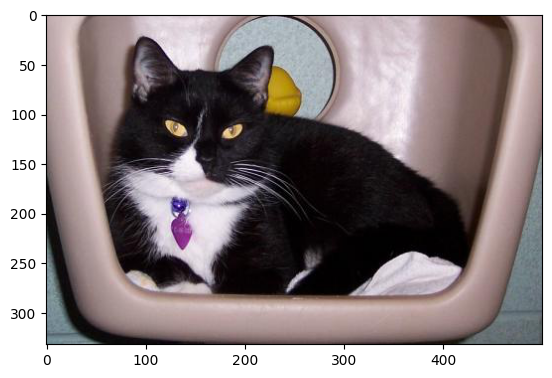

In [66]:
img = Image.open('./catsdogs/CatsDogs/Cats/cat_6590.jpg')
img_array = np.asarray(img)
#plt.subplot(3, 3, index+1)
plt.imshow(img)
plt.show() 

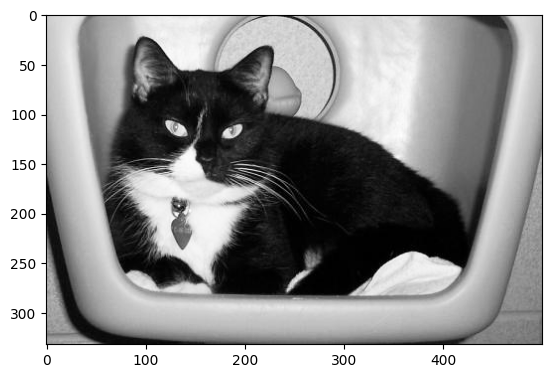

In [67]:
img = img.convert('L') #greyscaling images
img_array2 = np.asarray(img)
plt.imshow(img,cmap='Greys_r')
plt.show()

There are images that have nothing to do with cats and dogs!!

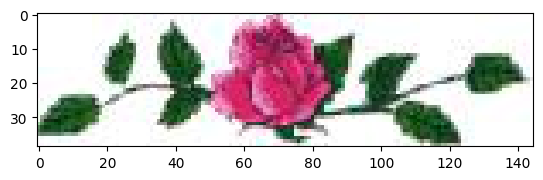

In [62]:
img = Image.open('./catsdogs/CatsDogs/Cats/cat_9171.jpg')
img_array = np.asarray(img)
#plt.subplot(3, 3, index+1)
plt.imshow(img)#,cmap='Greys_r') 
plt.show()

In [ ]:
#REMOVING IMAGES NOT ABOUT CATS AND DOGS
to_remove = {
  'Dogs/' : [ '5604.jpg',
            '4367.jpg',
            '1773.jpg',
            '10797.jpg'],
  'Cats/' : ['9171.jpg']
}
for key in to_remove:
  for image in to_remove[key]:
    os.remove(path+image)


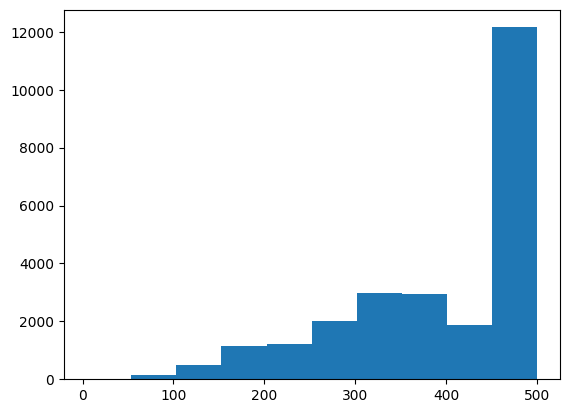

In [ ]:
#DISTRIBUTION OF IMAGE HEIGHTS
plt.hist(heights)
plt.show()

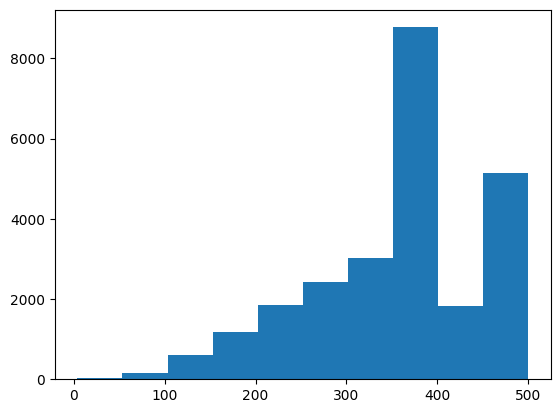

In [ ]:
#DISTRIBUTION OF IMAGE WIDTHS
plt.hist(widths)
plt.show()

##dataset

In [ ]:
#CLASS RELATED TO THE IMAGE DATASET

class Dataset():

  def __init__(self, path):
    self.path = path
    #self.labels = []
    #self.images = []
    self.df_images = pd.DataFrame(columns = ['image','label'])
    self.train_ds = None
    self.val_ds = None
    self.test_ds = None


  def create_dataset(self):
    images = []
    labels = []
    images_app = labels_app = []
    #data = pd.DataFrame(columns = ['image','label'])
    for (root,dirs,files) in os.walk(self.path, topdown=True):

      if len(files) > 0:
        dir = root.split('/')[-1]
        dir = 'cat' if dir == 'Cats' else 'dog'
        labels_app, images_app = self.explore_path(root, files, dir)
        images.extend(images_app)
        labels.extend(labels_app)

    self.df_images['image'] = pd.Series(images)
    self.df_images['label'] = pd.Series(labels)

  def explore_path(self, root, files, dir):
    labels = []
    images = []
    damaged = []
    damaged_images = []
    damaged_imgs = 0
    fnames = list(fname for fname in files if fname.endswith('.jpg'))

    batchsize = 500
    l_index, r_index = 0, batchsize
    batch = fnames[l_index:r_index]
    while batch:

      for i in batch:
          #import_function(i) 
        try:
          img = Image.open(root+'/'+i)    # Open image as PIL image object
          if img.mode != 'RGB':
            img = img.convert('RGB')
            damaged.append(i)

          #img = img.convert('L') #greyscaling images
          img.save(root+'/'+i)
          
          if 'cat' not in i and 'dog' not in i:
            os.rename(root+'/'+i, root+f'/{dir}_'+i)
          images.append(f'/{dir}_'+i)
          labels.append(0 if dir == 'cat' else 1)
        except UnidentifiedImageError:
          #print('IMAGE DAMAGED: '+i)
          damaged_images.append(i)
          #if os.path.exists(root+'/'+i):
          os.remove(root+'/'+i)
          damaged_imgs+=1
      l_index, r_index = r_index, r_index + batchsize
      batch = fnames[l_index:r_index]
      print(f'DELETED {damaged_imgs} IMAGES OF {dir}')
      print(f'THERE ARE {len(images)} IMAGES OF {dir}')
      print(f'THERE ARE {len(labels)} IMAGES OF {dir}')
    return labels,images

  def get_dataset(self):
    return self.df_images

  def split_train_val_test(self):
    self.df_images['image'] = self.df_images['image'].apply(lambda x: self.path+"Dogs"+x if 'dog' in x.split('/')[1] else self.path+"Cats"+x )
    self.df_images['label'] = self.df_images['label'].apply(lambda x: 'dog' if x == 1 else 'cat')

    self.train_ds, test_val = train_test_split(self.df_images, test_size=0.2, random_state=42)
    self.test_ds, self.val_ds = train_test_split(test_val, test_size=0.5, random_state=42)
  
  def get_train_set(self):
    return self.train_ds

  def get_val_set(self):
    return self.val_ds
  
  def get_test_set(self):
    return self.test_ds

  def get_images_set(self):
    return self.df_images


In [ ]:
ds = Dataset("./catsdogs/CatsDogs/")

ds.create_dataset()
ds.get_dataset()

In [ ]:
ds.split_train_val_test()

<Axes: >

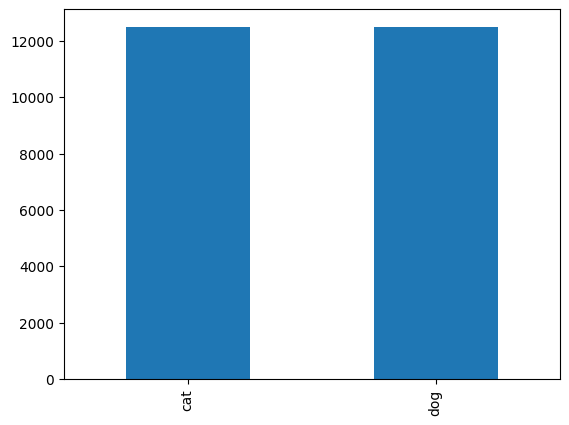

In [ ]:
ds.get_images_set()['label'].value_counts().plot.bar()

Dataset is balanced

In [ ]:
#CAT = 0, DOG = 1

In [69]:
train_datagen=ImageDataGenerator(
rotation_range=15,
rescale=1./255,#)
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

In [70]:
example_df = ds.get_train_set().sample(n=1)
example_generator = train_datagen.flow_from_dataframe(
    example_df,  
    x_col="image",
    y_col="label",
    target_size=(200, 200),
    class_mode="categorical",
    color_mode="grayscale",
    seed = 17,
    batch_size=32
)

Found 1 validated image filenames belonging to 1 classes.


EXAMPLE OF IMAGE AUGMENTATION

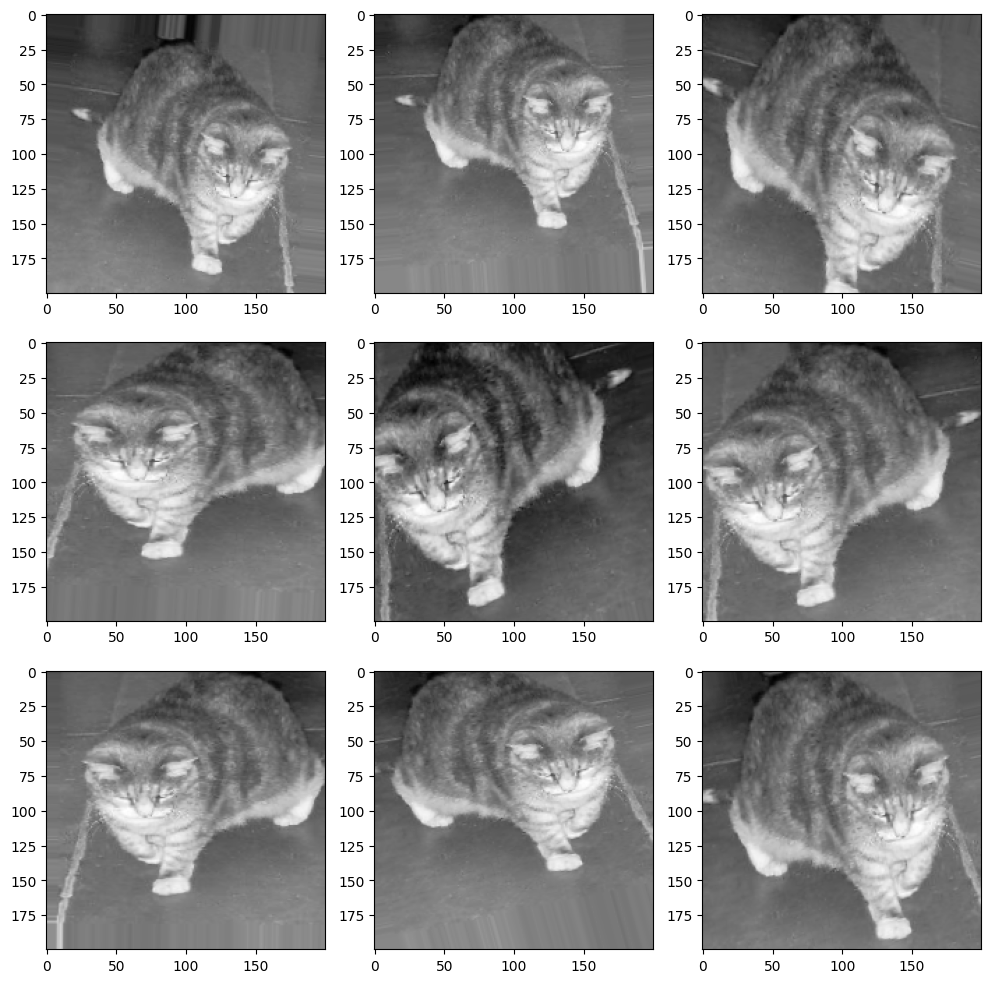

In [71]:
plt.figure(figsize=(10, 10))
#for i in range(0, 15):
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        #print(image)
        plt.imshow(image,cmap='Greys_r')
        break
plt.tight_layout()
plt.show()

# Classes and functions

In [ ]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines (works on CPU too)

In [ ]:
#NEURAL NETWORK CLASS.

class CNN_Model():
  def __init__(self, type = 'cnn'):
    self.type = type
    self.train_ds = None
    self.val_ds = None
    self.test_ds = None
    self.history = None
    self.df_images = pd.DataFrame()
    self.model_params = {}
    self.cv_scores = []

    with strategy.scope():
      if type == 'cnn':
        
        self.model = keras.models.Sequential()
      
      elif type == 'vgg16':
        self.model = VGG16(input_shape=(img_width,img_height, 3), include_top=False, weights="imagenet")
      
      elif type == 'resnet':
        self.model = ResNet50(weights = 'imagenet' , include_top = False , input_shape = (img_width,img_height, 3))

      else:
        raise Exception("No model!!!!")

#model.build_model([32,64,64,128,256],0,[(3,3),(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[1.0,1.0,1.0,1.0,1.0],True,[128],[0.5])

  def build_model(self,layers=[], batch_size=32,filter_shape=[],input_shape=(200,200,1), padding = 'same', dropout=[], batch_normalization = False, layers_flatten = [], dropout_flatten=[],lr_decay = True, early_termination = True, lr = 0.001):
    #model = keras.models.Sequential()

    self.model_params = {
        'layers' : layers,
        'batch_size':batch_size,
        'filter_shape':filter_shape,
        'input_shape':input_shape, 
        'padding':padding, 
        'dropout':dropout, 
        'batch_normalization':batch_normalization, 
        'layers_flatten' :layers_flatten, 
        'dropout_flatten':dropout_flatten, 
        'lr':lr
    }
    with strategy.scope():
      if self.type == 'cnn':

    
        self.model.add(tf.keras.layers.Conv2D(layers[0], filter_shape[0], input_shape=input_shape, padding=padding)) 
        if batch_normalization == True:                                       
          self.model.add(tf.keras.layers.BatchNormalization(scale=False, center=True))
        
        self.model.add(tf.keras.layers.Activation('relu'))
        #tf.keras.layers.MaxPooling2D(2,2)
        self.model.add(tf.keras.layers.MaxPooling2D(2, 2))

        if dropout[0] < 1.0:                                       
          self.model.add(tf.keras.layers.Dropout(dropout[0]))

        for i in range(1,len(layers)):
          #print(i)
          self.model.add(tf.keras.layers.Conv2D(layers[i], filter_shape[i], padding='same'))#, strides = 2))
          if batch_normalization == True:                                       
            self.model.add(tf.keras.layers.BatchNormalization(scale=False, center=True))
          
          self.model.add(tf.keras.layers.Activation('relu'))
          self.model.add(tf.keras.layers.MaxPooling2D(2, 2))
          
          #print(dropout[i])
          if dropout[i] < 1.0:                                       
            self.model.add(tf.keras.layers.Dropout(dropout[i]))
          #self.model.add(tf.keras.layers.MaxPooling2D(2, 2))


        self.model.add(tf.keras.layers.Flatten())
        for y in range(len(layers_flatten)):
            self.model.add(tf.keras.layers.Dense(layers_flatten[y], activation='relu'))
            if batch_normalization == True:                                       
              self.model.add(tf.keras.layers.BatchNormalization(scale=False, center=True))
            if dropout_flatten[y] < 1.0:                                       
              self.model.add(tf.keras.layers.Dropout(dropout_flatten[y]))
        self.model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        #self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])


      elif self.type == 'vgg16':
        for layer in self.model.layers[:15]:
          layer.trainable = False

        for layer in self.model.layers[15:]:
            layer.trainable = True
            
        last_layer = self.model.get_layer('block5_pool')
        last_output = last_layer.output
            
        x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        # Add a final sigmoid layer for classification
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        model_final = Model(self.model.input, x)

        model_final.compile(loss='binary_crossentropy',
                      optimizer=SGD(learning_rate=1e-4, momentum=0.9),
                      metrics=['accuracy'])

        self.model = model_final
      elif self.type == 'resnet':
        X_input = keras.layers.Input(shape=(img_width, img_height, 3), name='input')

        x = self.model(X_input)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dropout(0.3)(x)
        out = keras.layers.Dense(1, activation='sigmoid')(x)
        model_final = Model(X_input, [out])

        model_final.compile(loss='binary_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])

        self.model = model_final
      #return self.model


  def fit_model(self, epochs =20, learning_decay = True,early_termination = True):
    plot_training = PlotTraining(sample_rate=10, zoom=1)   
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
    # lr schedule callback: decreasing learning rate every epoch passes
    lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

    callbacks_list = [plot_training]  
    if lr_decay == True: 
      callbacks_list.append(lr_decay_callback)
    if early_termination == True: 
      callbacks_list.append(stop_early)
    self.history = self.model.fit(self.train_ds, epochs=epochs,
                        validation_data=self.val_ds, verbose=1, callbacks=callbacks_list)
    
    
  def generate_data(self,df,train,val,test,augment_img = False):
    self.df_images = copy.deepcopy(df)

    if augment_img == True:
      train_datagen=ImageDataGenerator(
      rotation_range=15,
      rescale=1./255 if self.type != 'resnet' else 1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      width_shift_range=0.1,
      height_shift_range=0.1)
    else:
      train_datagen=ImageDataGenerator(rescale=1./255 if self.type != 'resnet' else 1)

    if self.type == 'vgg16' or self.type == 'resnet':
      color = 'rgb'
      rescale_img = 1
    else:
      color = 'grayscale'
      rescale_img = 1./255

    self.train_ds=train_datagen.flow_from_dataframe(dataframe=train,
                                                        x_col="image",
                                                        y_col="label",
                                                        target_size=(img_width, img_height),
                                                        class_mode="binary",
                                                        color_mode=color,
                                                        seed = 17,
                                                        batch_size=32)
    


    val_gen = ImageDataGenerator(rescale=1./255 if self.type != 'resnet' else 1)
    self.val_ds=val_gen.flow_from_dataframe(dataframe=val,
                                                      x_col="image",
                                                      y_col="label",
                                                      target_size=(img_width, img_height),
                                                      class_mode="binary",
                                                      color_mode=color,
                                                      seed = 17,
                                                      batch_size=32)
    

    test_gen = ImageDataGenerator(rescale=1./255 if self.type != 'resnet' else 1)
    self.test_ds=test_gen.flow_from_dataframe(dataframe=test,
                                                      x_col="image",
                                                      y_col="label",
                                                      target_size=(img_width, img_height),
                                                      class_mode="binary",
                                                      color_mode=color,
                                                      shuffle = False,
                                                      batch_size=32)
    
    #return train_ds, val_ds,test_ds

  def print_summary(self):
    print(self.model.summary())

  def cross_validation(self):
    
    return 0


  def get_x_y_data(self):
    self.df_images = self.df_images.sample(frac=1)
    train_x = self.df_images['image'].values
    #train_y = train['label'].apply(lambda x : 1 if x == 'dog' else 0).values
    train_y = self.df_images['label'].values

    return train_x, train_y

  def cross_validate(self):
    model = self.model
    scores = []
    accuracies = []
    train_datagen=ImageDataGenerator(
      rotation_range=15,
      rescale=1./255 if self.type != 'resnet' else 1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      width_shift_range=0.1,
      height_shift_range=0.1
    )

    if self.type == 'vgg16' or self.type == 'resnet':
      color = 'rgb'
      rescale_img = 1
    else:
      color = 'grayscale'
      rescale_img = 1./255

    val_datagen = ImageDataGenerator(rescale=1./255 if self.type == 'cnn' or self.type == 'vgg16' else 1)
    k = 0
    kfold = KFold(2, shuffle = True, random_state = 42)
    x_data, y_data = self.get_x_y_data()

    for train_ix, val_ix in kfold.split(x_data):
      k+=1
      xx_train, yy_train, xx_val, yy_val = x_data[train_ix], y_data[train_ix], x_data[val_ix], y_data[val_ix] 
      train_generator = train_datagen.flow_from_dataframe(
          dataframe = pd.DataFrame({'image' : xx_train, 'label' : yy_train}),
          x_col="image",
          y_col="label",
          target_size=img_size,
          class_mode="binary",
          color_mode=color,
          seed = 17,
          batch_size=batch_size,
          #shuffle = False
      )
      len_val_df = len(pd.DataFrame({'image' : xx_val, 'label' : yy_val}))
      val_generator = val_datagen.flow_from_dataframe(
          dataframe = pd.DataFrame({'image' : xx_val, 'label' : yy_val}),
          x_col="image",
          y_col="label",
          target_size=img_size,
          class_mode="binary",
          color_mode=color,
          seed = 17,
          batch_size=batch_size,
          #shuffle = False
      )
      #model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_cats_dogs.h5', verbose=1, save_best_only=True)



      metrics = Metrics(val_generator,self.model)
      history = model.fit(train_generator,
                        epochs=2,  # The more we train the more our model fits the data
                        batch_size=batch_size,  # Smaller batch sizes = samller steps towards convergence
                        validation_data=val_generator,
                        verbose=1,callbacks=[lr_decay_callback,stop_early,metrics,])#model_checkpoint])

      _, acc = model.evaluate(val_generator)
      print('ACCURACY MODEL JUST FINISHED: ... ',acc)
      metric = metrics.get_data()
      self.cv_scores.append({'acc':history.history['accuracy'][-1],'val_acc':history.history['val_accuracy'][-1], 'zero-one-loss':metric[-1]['zero_one_loss'], 'loss': history.history['loss'][-1],'val_loss': history.history['val_loss'][-1],'val_df_size': len_val_df, 'results_loss_epochs': metric})
      accuracies.append(acc)
      df_final = pd.DataFrame.from_dict(self.cv_scores)
      df_final.to_csv(f'vgg16_cv_results_fold{k}.csv')
      files.download(f'vgg16_cv_results_fold{k}.csv') 
      self.build_model(**self.model_params)

  def evaluate_model(self):
    self.y_val = self.test_ds.classes
    self.y_pred =  self.model.predict(self.test_ds)
    threshold = 0.5
    self.y_pred = np.where(self.y_pred > threshold, 1,0)

    eval = self.model.evaluate(self.test_ds)
    precision = precision_score(self.y_val, self.y_pred)
    recall = recall_score(self.y_val, self.y_pred)
    f1 = f1_score(self.y_val, self.y_pred)

    
    print(f"Test loss: {eval[0]} - Test accuracy: {eval[1]}")
    print('Precision: %f' % precision)
    print('Recall: %f' % recall)
    print('F1 score: %f' % f1)


  def print_confusion_matrix(self):
    confusion_mtx = confusion_matrix(self.y_val, self.y_pred) 

    labels_axis = ['Cat','Dog']
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_mtx.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        confusion_mtx.flatten()/np.sum(confusion_mtx)]
    labels = [f"{v1}\n{v2}\n{v3}".strip() for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)


    accuracy = accuracy_score(self.y_val, self.y_pred)
    precision = precision_score(self.y_val, self.y_pred)
    recall = recall_score(self.y_val, self.y_pred)
    f1 = f1_score(self.y_val, self.y_pred)

    f = plt.figure(figsize=(5,5))
    #sns.heatmap(confusion_mtx, annot=labels, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
    sns.heatmap(confusion_mtx,fmt="", annot=labels, cmap='Greens', linewidths=2,annot_kws={'fontfamily':'serif','size':14,'weight':'bold'},xticklabels=labels_axis,yticklabels=labels_axis,)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label" + stats_text, **{'fontfamily':'serif','size':12,'weight':'bold'})
    plt.title("Confusion Matrix")
    plt.show()

  def print_cv_results(self):
    df_results = pd.DataFrame.from_dict(self.cv_scores)
    plt.figure(figsize=(18, 5))
    for index,results in df_results.iterrows():
      loss_results = ast.literal_eval(results['results_loss_epochs'])
      epochs = [item['step'] for item in loss_results]
      loss = [item['zero_one_loss'] for item in loss_results]
      #print(epochs)
      plt.subplot(1, 5, index+1)
      plt.title(f"0-1 Loss after fold {index+1}")
      plt.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
      plt.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
      #plt.figure(figsize=(5,5))
      accuracy = results['val_acc']
      loss = results['zero-one-loss']
      loss_perc = loss / results['val_df_size']
      stats_text = "\n\nAccuracy={:0.3f}\n0-1 Loss={:0.3f} - {:0.3f}".format(accuracy,loss,loss_perc)
      #plt.xlabel("Predicted Label" + stats_text, **{'fontfamily':'serif','size':12,'weight':'bold'})
      plt.xlabel("Epochs" + stats_text, **{'fontfamily':'serif','weight':'bold'})
      plt.ylabel("Loss")
      plt.xticks(np.arange(0, 21, 2))
      plt.plot(epochs, loss)
    plt.show()
    

In [ ]:
class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    #self.steps_per_epoch = len(ds.get_train_set())
    self.steps_per_epoch = round(len(ds.get_train_set())/batch_size)

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

In [ ]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
# lr schedule callback: decreasing learning rate every epoch passes
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

In [ ]:
class Metrics(keras.callbacks.Callback):
    def __init__(self, validation_data,model):
        self.valid_data = validation_data
        self.model_cnn = model
        self.step = 1
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, epoch, logs={}):
        loss = []
        i = 0
        y_val = self.valid_data.classes
        y_predict = self.model.predict(self.valid_data)

        threshold = 0.5
        y_final = np.where(y_predict > threshold, 1,0)
        for i,item in enumerate(y_val):
          loss.append(0 if y_val[i] == y_final[i] else 1)
        print('ACCURACY SCORE: ', accuracy_score(y_val, y_final))
        print(f'LOSS= {sum(loss)} - epoch = {epoch} - step= {self.step}')
        self._data.append({
            'zero_one_loss': sum(loss),
            'epoch': epoch,
            'step': self.step
        })
        self.step+=1
        return

    def get_data(self):
        return self._data

In [ ]:
def cross_validate(model_v,dataset):

  scores = []

  if model_v.type == 'vgg16' or model_v.type == 'resnet':
    color = 'rgb'
    rescale_img = 1
  else:
    color = 'grayscale'
    rescale_img = 1./255
  train = dataset.get_train_set()
  val = dataset.get_train_set()
  ds_cv = pd.concat([train,val])
  x_data = ds_cv['image'].values
  y_data = ds_cv['label'].values

  train_datagen=ImageDataGenerator(
    rotation_range=15,
    #rescale=1./255,
    rescale=1./255 if model_v.type != 'resnet' else 1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
  )
  accuracies = []
  #val_datagen = ImageDataGenerator(rescale=1./255)
  val_datagen = ImageDataGenerator(rescale=1./255 if model_v.type == 'cnn' or model_v.type == 'vgg16' else 1)



  kfold = KFold(5, shuffle = True, random_state = 42)
  k = 0
  for train_ix, val_ix in kfold.split(x_data):
    k+=1
    xx_train, yy_train, xx_val, yy_val = x_data[train_ix], y_data[train_ix], x_data[val_ix], y_data[val_ix] 

    train_generator = train_datagen.flow_from_dataframe(
        dataframe = pd.DataFrame({'image' : xx_train, 'label' : yy_train}),
        x_col="image",
        y_col="label",
        target_size=img_size,
        class_mode="binary",
        color_mode=color,
        seed = 17,
        batch_size=batch_size
        #shuffle = False
    )
    len_val_df = len(pd.DataFrame({'image' : xx_val, 'label' : yy_val}))
    val_generator = val_datagen.flow_from_dataframe(
        dataframe = pd.DataFrame({'image' : xx_val, 'label' : yy_val}),
        x_col="image",
        y_col="label",
        target_size=img_size,
        class_mode="binary",
        color_mode=color,
        #seed = 17,
        batch_size=batch_size,
        shuffle = False
    )
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model_v.type}_fold_{k}_best_cats_dogs.h5', verbose=1, save_best_only=True)

    metrics = Metrics(val_generator,model_v.model)
    history = model_v.model.fit(train_generator,
                      epochs=20,  # The more we train the more our model fits the data
                      batch_size=batch_size,  # Smaller batch sizes = samller steps towards convergence
                      validation_data=val_generator,
                      verbose=1,callbacks=[lr_decay_callback,stop_early,metrics,model_checkpoint])
    _, acc = model_v.model.evaluate(val_generator)
    print('ACCURACY MODEL JUST FINISHED: ... ',acc)
    metric = metrics.get_data()
    scores.append({'acc':history.history['accuracy'][-1],'val_acc':history.history['val_accuracy'][-1], 'zero-one-loss':metric[-1]['zero_one_loss'], 'loss': history.history['loss'][-1],'val_loss': history.history['val_loss'][-1],'val_df_size': len_val_df, 'results_loss_epochs': metric})
    accuracies.append(acc)
    df_final = pd.DataFrame.from_dict(scores)
    #print(df)
    df_final.to_csv(f'{model_v.type}_cv_results_fold{k}.csv')
    files.download(f'{model_v.type}_cv_results_fold{k}.csv') 
    files.download(f'{model_v.type}_fold_{k}_best_cats_dogs.h5')
    #if model_v.type == 'cnn':
    model_params = model_v.model_params
    #model_v = CNN_Model('resnet')
    if model_v.type == 'cnn':
      model_v = CNN_Model()
      model_v.build_model(**model_params)
    else:
      if model_v.type =='vgg16':
        model_v = CNN_Model('vgg16')
      else:
        model_v = CNN_Model('resnet')
      model_v.build_model()

  return scores


#print('starting cross validation training....')

#scores = cross_validate(model_vgg, ds)

# Neural network

In [ ]:
pa = "./catsdogs/CatsDogs/"

In [ ]:
epochs = 10
batch_size = 32
img_height = 200
img_width = 200
img_size = (200,200)

First neural network with a single layer

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(img_height,img_width,)),
      tf.keras.layers.Reshape((img_height*img_width,), input_shape=((img_height,img_width,))),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 40000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 40001     
                                                                 
Total params: 40,001
Trainable params: 40,001
Non-trainable params: 0
_________________________________________________________________


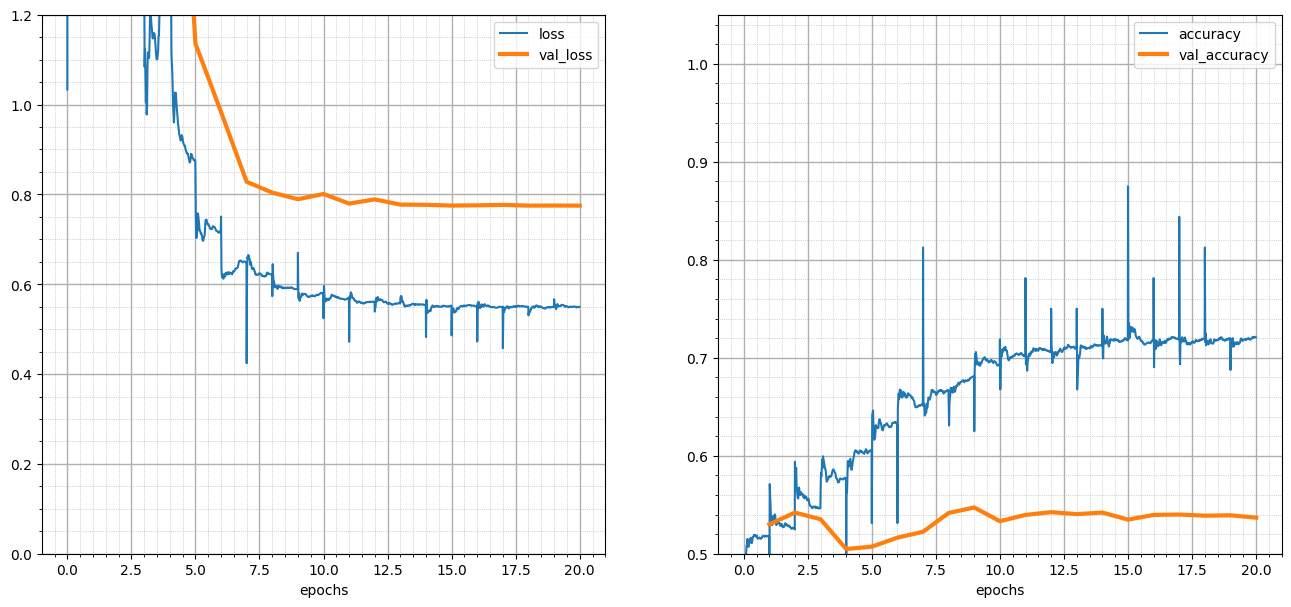

625/625 [==============================] - 60s 96ms/step - loss: 0.5494 - accuracy: 0.7206 - val_loss: 0.7750 - val_accuracy: 0.5368 - lr: 6.0936e-07


In [ ]:
history = model.fit(train_datagenerator, epochs=20,
                    validation_data=val_datagenerator, verbose=1, callbacks=[plot_training, lr_decay_callback])

## Going deeper

In [ ]:
with strategy.scope():
  model_deep = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(img_height,img_width,)),
      tf.keras.layers.Reshape((img_height*img_width,), input_shape=((img_height,img_width,))),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model_deep.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# print model layers
model_deep.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)   


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 40000)             0         
                                                                 
 dense_1 (Dense)             (None, 200)               8000200   
                                                                 
 dense_2 (Dense)             (None, 60)                12060     
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 8,012,321
Trainable params: 8,012,321
Non-trainable params: 0
_________________________________________________________________


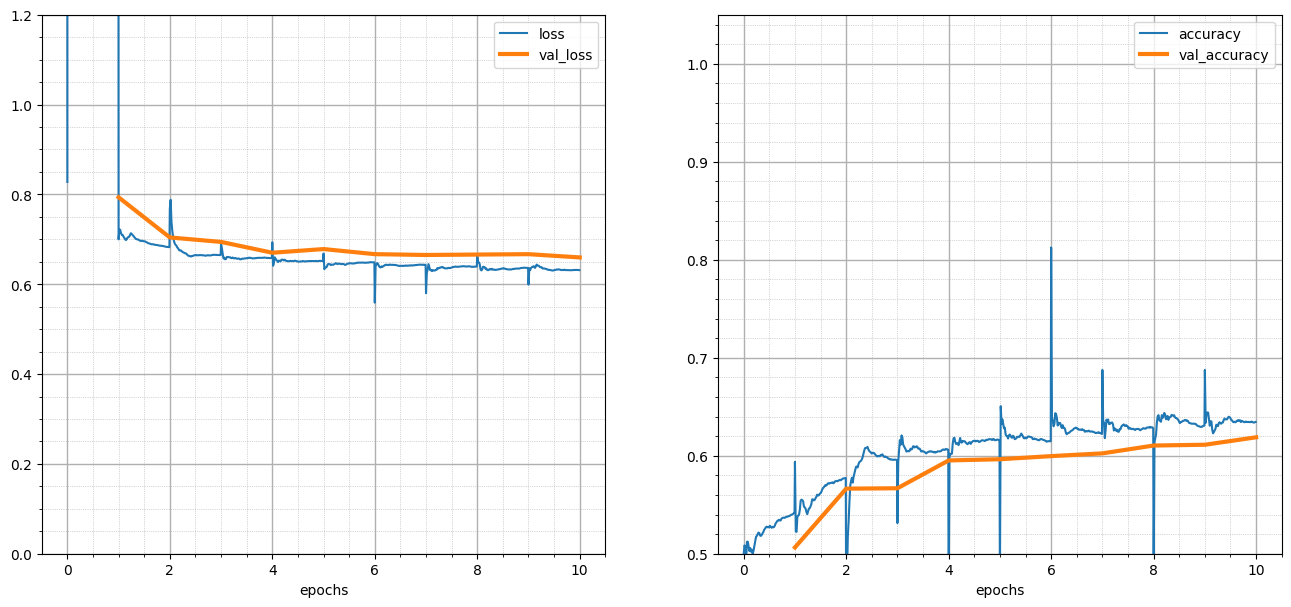

625/625 [==============================] - 63s 100ms/step - loss: 0.6313 - accuracy: 0.6346 - val_loss: 0.6596 - val_accuracy: 0.6188 - lr: 1.0078e-04


In [ ]:
#TRIAL WITH DEEP
history = model_deep.fit(train_datagenerator, epochs=10,
                    validation_data=val_datagenerator, verbose=1, callbacks=[plot_training, lr_decay_callback])

# CNN

## 2 convolutional layers CNN

First CNN with 2 convolutional layers

In [ ]:
model = CNN_Model()

model.build_model([16,32],32,[(3,3),(3,3)],(200,200,1),'same',[1,1,1],False,[128],[1], False, False)
model.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set())

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model.print_summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 200, 200, 16)      160       
                                                                 
 activation_20 (Activation)  (None, 200, 200, 16)      0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 100, 100, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 activation_21 (Activation)  (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                 

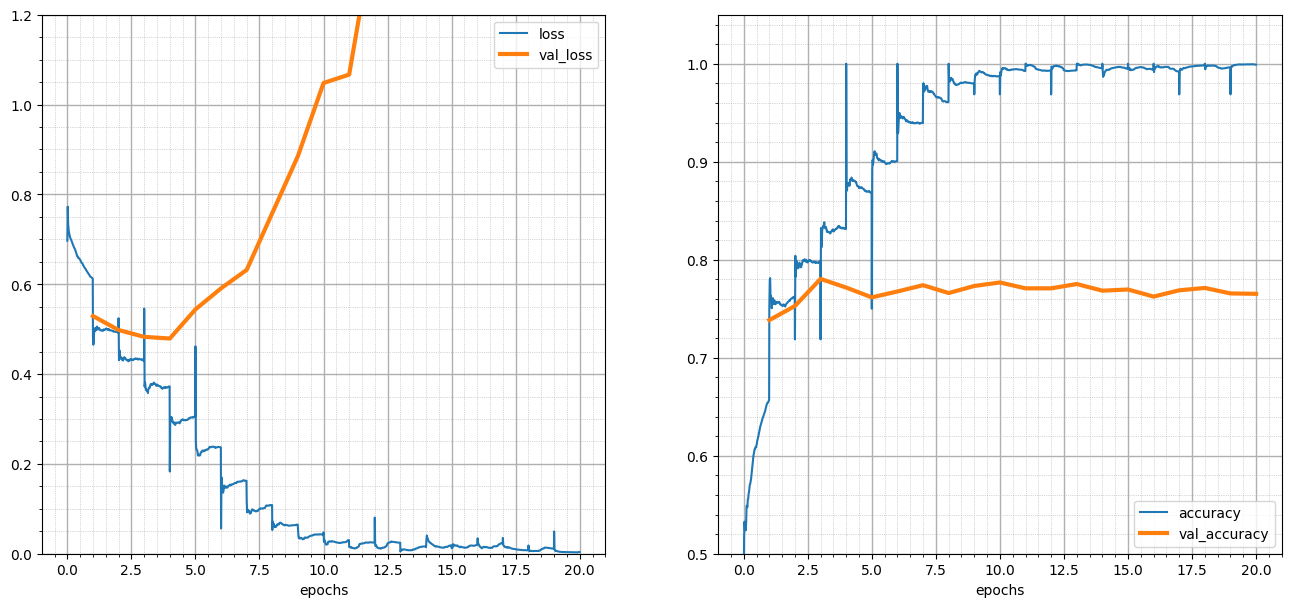

625/625 [==============================] - 65s 104ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 1.7292 - val_accuracy: 0.7652


In [ ]:
#WITHOUT AUGMENTATION
model.fit_model(False,False)

## 3 convolutional layers CNN

CNN with 3 convolutional layers

In [ ]:
model = CNN_Model()

model.build_model([16,32,64],32,[(3,3),(3,3),(3,3)],(200,200,1),'same',[1,1,1,1],False,[128],[1], False, False)
model.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model.print_summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 200, 16)      160       
                                                                 
 activation_6 (Activation)   (None, 200, 200, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 activation_7 (Activation)   (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

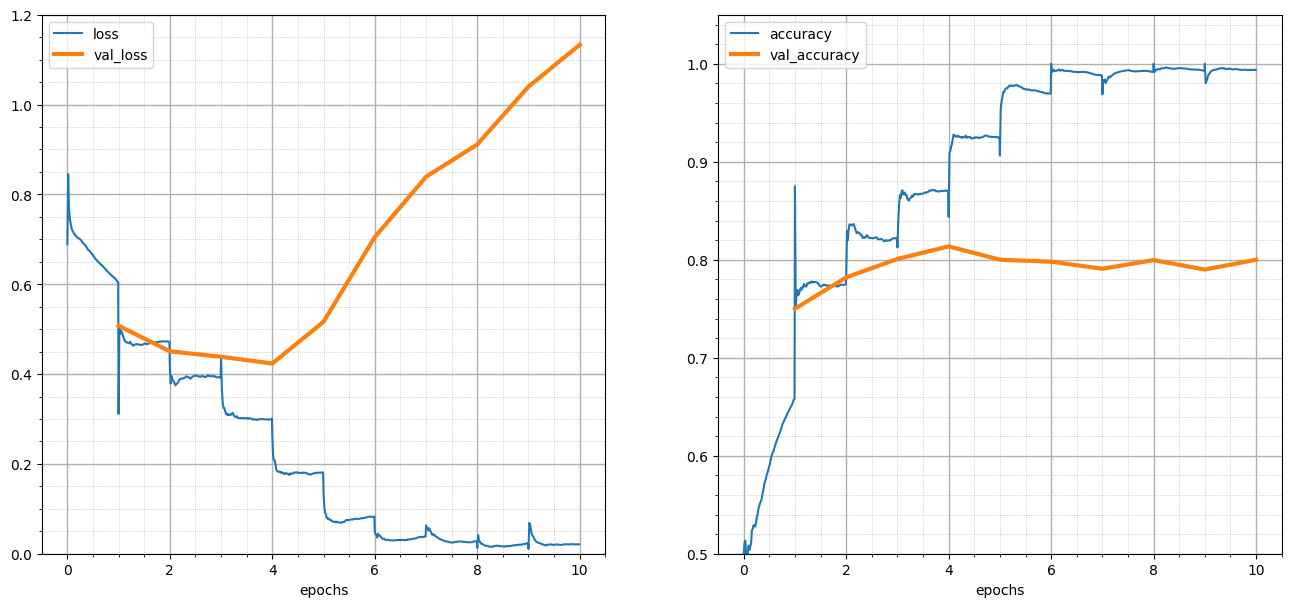

625/625 [==============================] - 62s 98ms/step - loss: 0.0214 - accuracy: 0.9934 - val_loss: 1.1331 - val_accuracy: 0.8000


In [ ]:
model.fit_model(10, False, False)

With 3 convolutional layers the network is able to learn more, but with huge amount of overfitting. I need to deal with it, by adding batch normalization and dropout layers, and "play around" with dropout rates to find the optimal ones

## CNN with batch_norm and dropout layers

In the same network as before, I added batch normalization layers after every conv. layer, and I started by putting a convolutional layer with rate 0.5 after the last dense layer.

I also added weight decay callback starting from learning rate of 0.01 and early termination. Bot are an attempt to mitigate overfitting

In [ ]:
model = CNN_Model()

model.build_model([16,32,64],32,[(3,3),(3,3),(3,3)],(200,200,1),'same',[1,1,1,1],True,[128],[0.5], True, True,0.01)
model.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model.print_summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      160       
                                                                 
 batch_normalization_4 (Batc  (None, 200, 200, 16)     48        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 200, 200, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 batch_normalization_5 (Batc  (None, 100, 100, 32)    

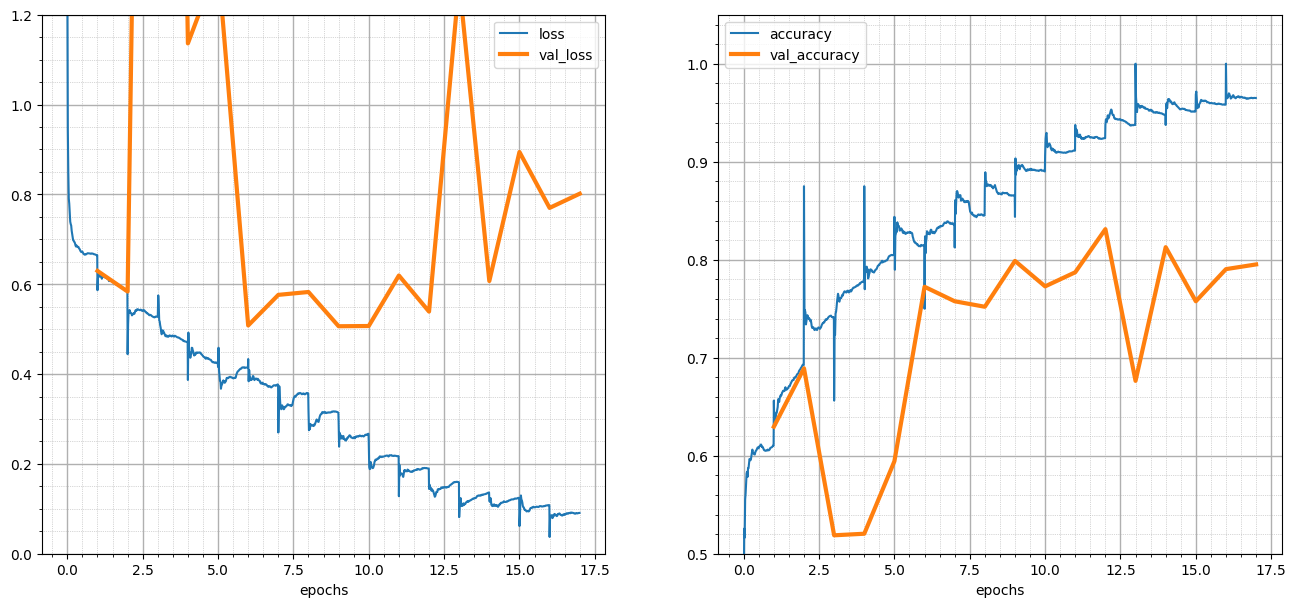

625/625 [==============================] - 66s 105ms/step - loss: 0.0911 - accuracy: 0.9650 - val_loss: 0.8015 - val_accuracy: 0.7952


In [ ]:
model.fit_model(20, True, True)

Doesn't seem to be improving much with the dropout of 0.5 on the dense layer. It also looks less "stable".

---------------------------------------------------------------------------------

In the next experiment I tried with a CNN with same structure as before, but with a dropout layer of 0.1 for each convolutional layer and one of rate 0.5 after the dense layer

I used different filter numbers for the convolutional layers (32,64,128)

In [ ]:
#SAME STRUCTURE AS BEFORE, BUT DIFFERENT FILTER NUMBERS PER LAYER
model = CNN_Model()



model.build_model([32,64,128],32,[(3,3),(3,3),(3,3)],(200,200,1),'same',[0.1,0.1,0.1,0.1],True,[128],[0.5], True, True,0.01)
model.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model.print_summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_66 (Bat  (None, 200, 200, 32)     96        
 chNormalization)                                                
                                                                 
 activation_52 (Activation)  (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_53 (Conv2D)          (None, 100, 100, 64)    

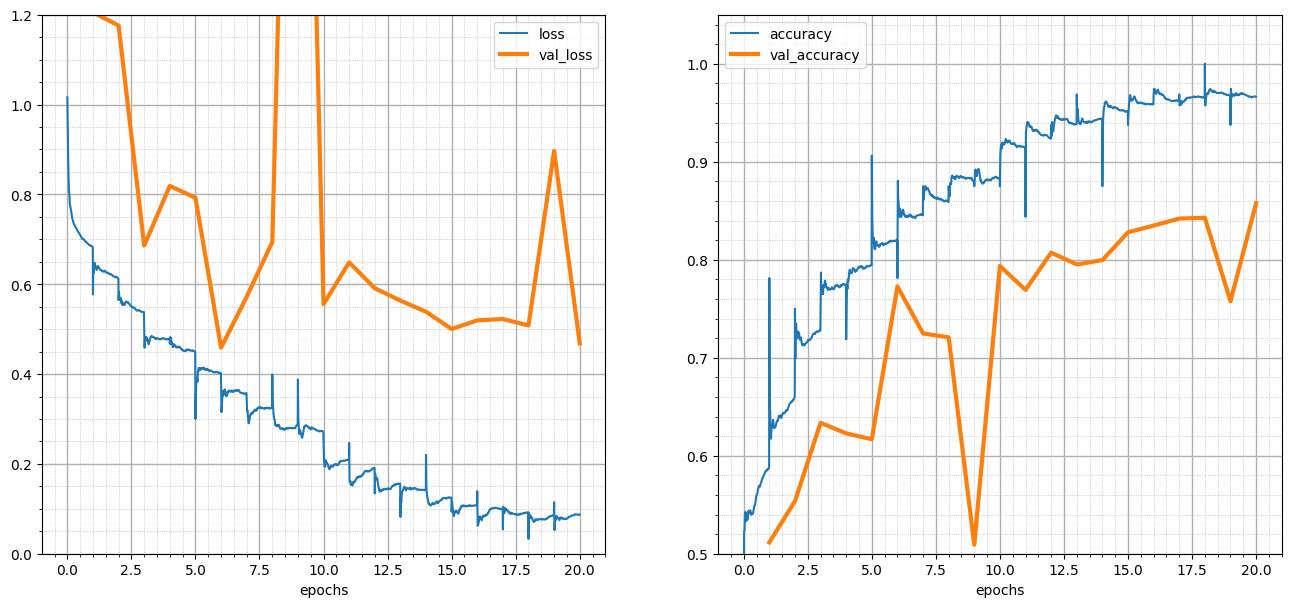

625/625 [==============================] - 73s 116ms/step - loss: 0.0876 - accuracy: 0.9661 - val_loss: 0.4685 - val_accuracy: 0.8576


In [ ]:
model.fit_model(20, True, True)

Overall better than before in terms of overfitting and predictive performance, but still overfitting quite a bit


### Playing around with dropout layers

I decided to experiment with dropout layers and rates to see what effect these changes have on the model

In [ ]:
model = CNN_Model()



model.build_model([32,64,128],32,[(3,3),(3,3),(3,3)],(200,200,1),'same',[0.2,0.2,0.2,0.2],True,[128],[0.5], True, True,0.01)
model.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model.print_summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 32)     96        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      1

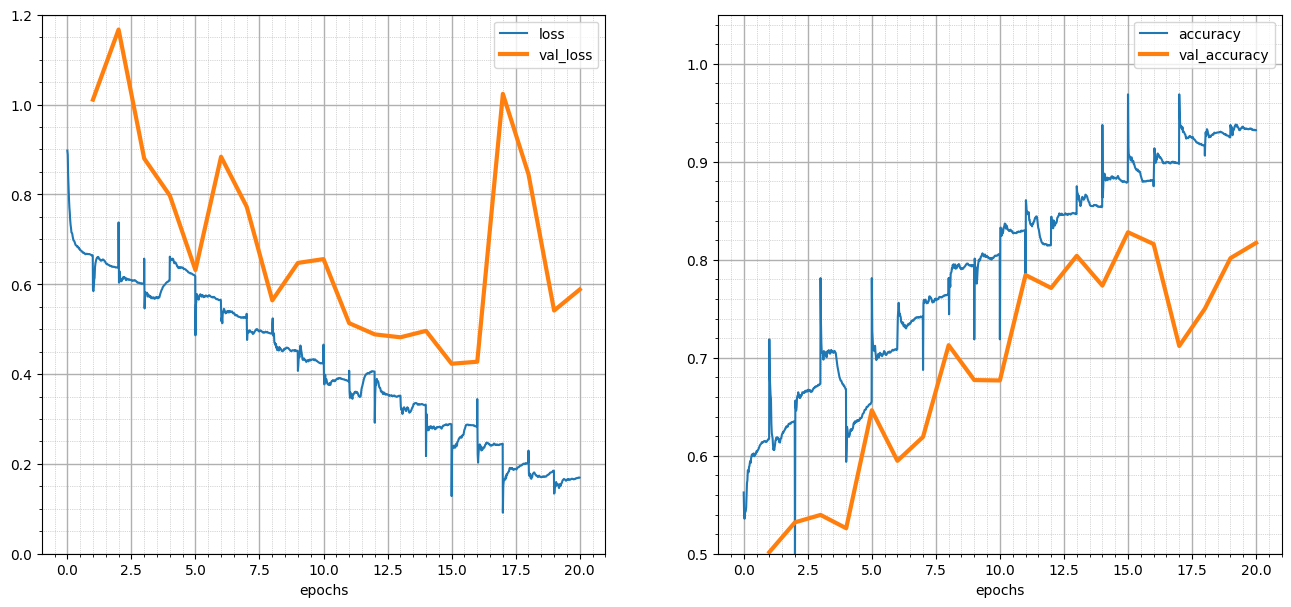

625/625 [==============================] - 71s 113ms/step - loss: 0.1701 - accuracy: 0.9321 - val_loss: 0.5882 - val_accuracy: 0.8172


In [ ]:
model.fit_model(20, True, True)


[0.2,0.2,0.2] seem to already make the model worse than with lower level of dropout rates

----------------------------------------------------------------------------------------------------------------------------------------------

[0.4,0.4,0.3] of dropout rates for conv. layers and 0.3 for dense

In [ ]:
model = CNN_Model()



model.build_model([32,64,128],32,[(3,3),(3,3),(3,3)],(200,200,1),'same',[0.4,0.4,0.3,0.2],True,[128],[0.3], True, True,0.01)
model.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model.print_summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 200, 200, 32)     96        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 64)     

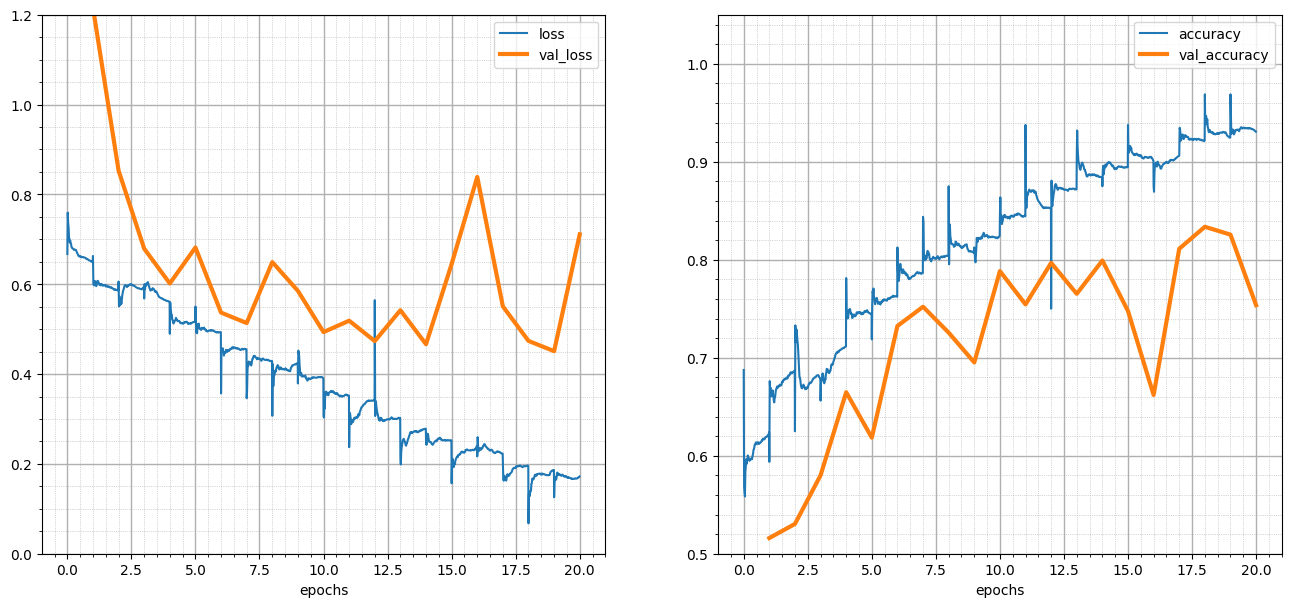

625/625 [==============================] - 69s 110ms/step - loss: 0.1721 - accuracy: 0.9307 - val_loss: 0.7111 - val_accuracy: 0.7536


In [ ]:
model.fit_model(20, True, True)


It's getting worse as i increase dropout rates.

Without any dropout layer

In [ ]:
model = CNN_Model()



model.build_model([32,64,128],32,[(3,3),(3,3),(3,3)],(200,200,1),'same',[1,1,1,1],True,[128],[1], True, True,0.01)
model.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model.print_summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_8 (Batc  (None, 200, 200, 32)     96        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 batch_normalization_9 (Batc  (None, 100, 100, 64)    

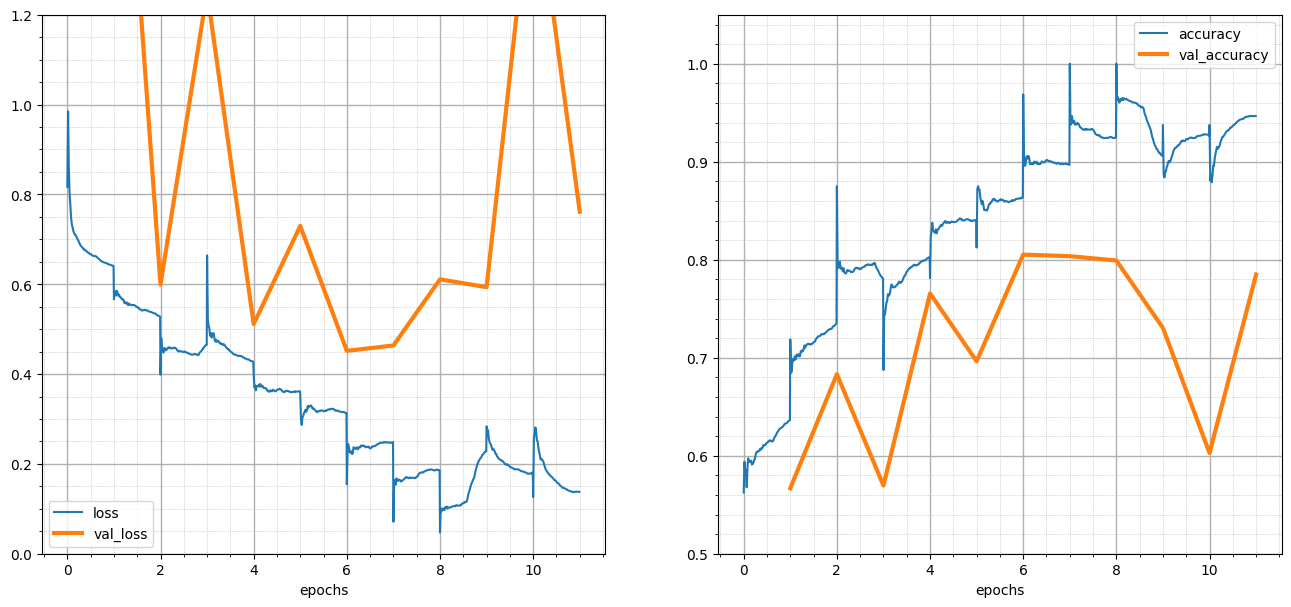

625/625 [==============================] - 65s 104ms/step - loss: 0.1376 - accuracy: 0.9466 - val_loss: 0.7616 - val_accuracy: 0.7848


In [ ]:
model.fit_model(20, True, True)


-------------------------------------------------------------------------------------------------------------------------

### 4 convolutional layers

Added a convolutional layer. The network is now composed of 4 convolutional layers with 32,64,128,256 as number of filters.

I added a dropout layer with rate 0.2 after each convolutional layer and one of 0.5 after the dense layer

In [ ]:
model = CNN_Model()



model.build_model([32,64,128,256],32,[(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[0.2,0.2,0.2,0.2],True,[128],[0.5], True, True,0.01)
model.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model.print_summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_12 (Bat  (None, 200, 200, 32)     96        
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 64)     

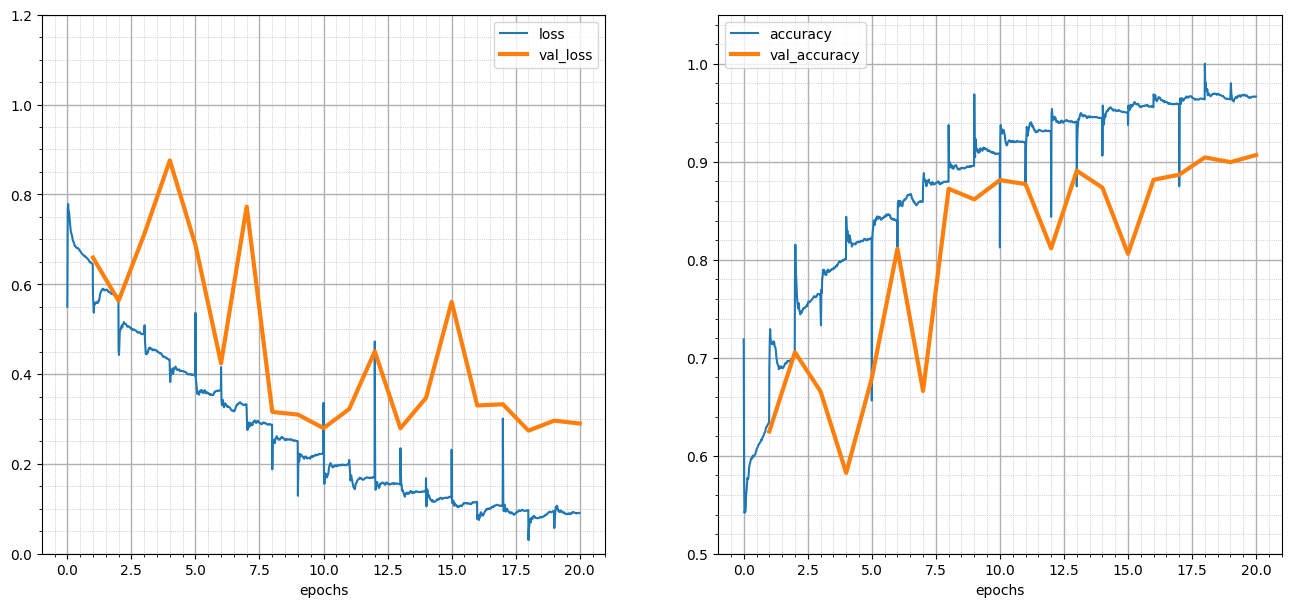

625/625 [==============================] - 74s 118ms/step - loss: 0.0905 - accuracy: 0.9665 - val_loss: 0.2899 - val_accuracy: 0.9068


In [ ]:
model.fit_model(20, True, True)


The results show a noticable improvement both in terms of overfitting and validation accuracy/loss

-----------------------------------------------------------------------------------------------------------------------------------------------------------

Now i will train the same network but with higher dropout rates to see if i can somehow improve the overfitting issue or not.

(Still using batch normalization, weight decay and early termination)

In [ ]:
model = CNN_Model()



model.build_model([32,64,128,256],32,[(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[0.3,0.3,0.3,0.3],True,[128],[0.5], True, True,0.01)
model.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model.print_summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_31 (Bat  (None, 200, 200, 32)     96        
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_26 (Conv2D)          (None, 100, 100, 64)     

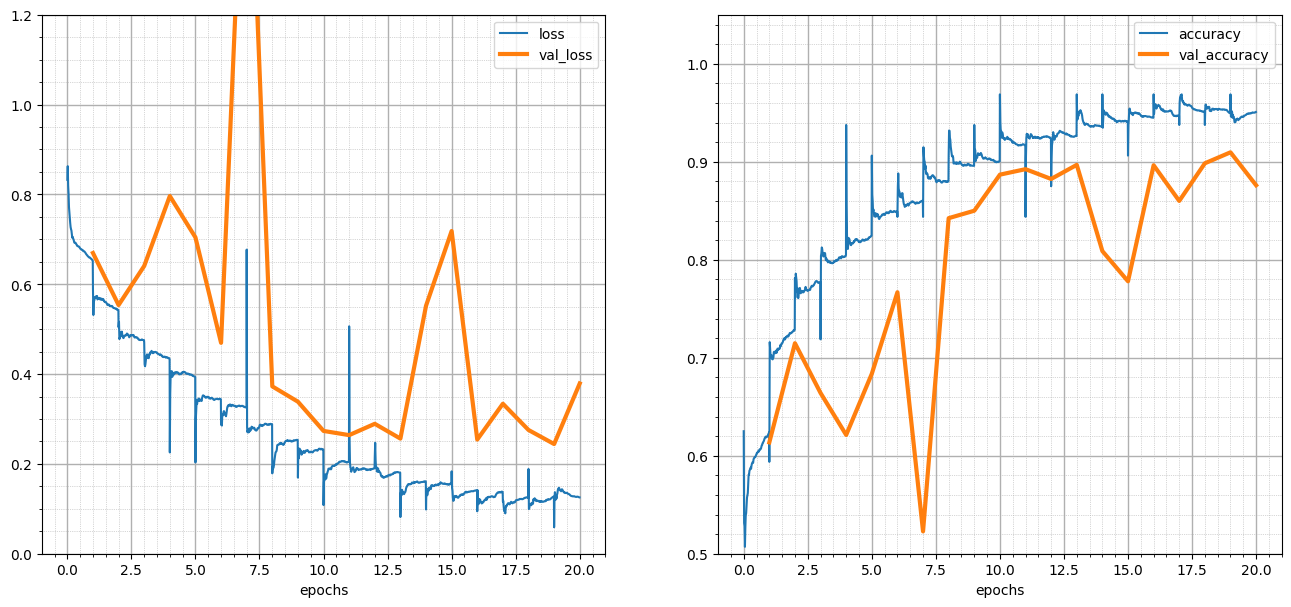

625/625 [==============================] - 94s 151ms/step - loss: 0.1253 - accuracy: 0.9507 - val_loss: 0.3791 - val_accuracy: 0.8760


In [ ]:
model.fit_model(20, True, True)


Didn't improve, in fact it's a bit worse. Looks like the dropout rate were a bit too high.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Last experiment with this network, and this time lowering dropout rates

0.1 of dropout rate after every conv. layer, and 0.5 after dense layer

In [ ]:
model = CNN_Model()



model.build_model([32,64,128,256],32,[(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[0.1,0.1,0.1,0.1],True,[128],[0.5], True, True,0.01)
model.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model.print_summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_18 (Bat  (None, 200, 200, 32)     96        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 100, 100, 64)     

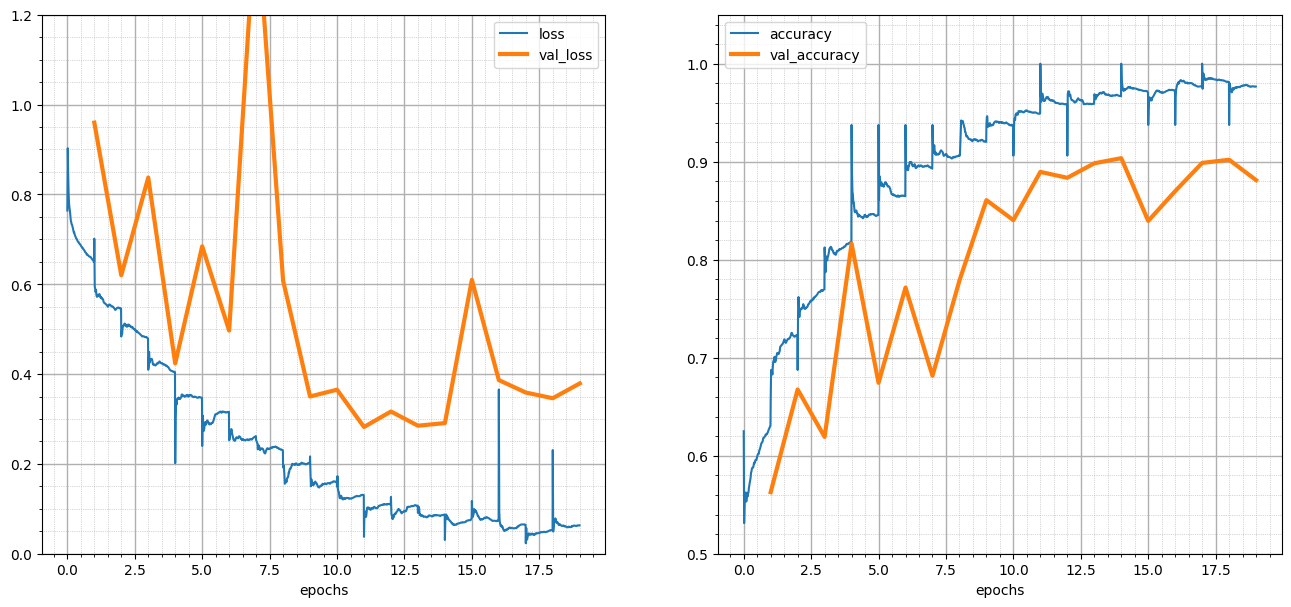

625/625 [==============================] - 92s 147ms/step - loss: 0.0631 - accuracy: 0.9767 - val_loss: 0.3791 - val_accuracy: 0.8812


In [ ]:
model.fit_model(20, True, True)


As expected, with lower dropout rates the overfitting becomes greater. In this case, since it's lower than in the first experiment the overfitting is bigger.

### 5 convolutional layers CNN

The network has 5 convolutional layers with 32,64,64,128,256 filters respectively.

In the first experiment I put 1 only dropout layer of 0.5 after the dense layer

In [ ]:
model_cnn = CNN_Model()

model_cnn.build_model([32,64,64,128,256],32,[(3,3),(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[0.5,0.5,0.5,0.5,0.5],True,[128],[0.5],True, True,0.01)
model_cnn.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model_cnn.print_summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_47 (Bat  (None, 200, 200, 32)     96        
 chNormalization)                                                
                                                                 
 activation_39 (Activation)  (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_40 (Conv2D)          (None, 100, 100, 64)    

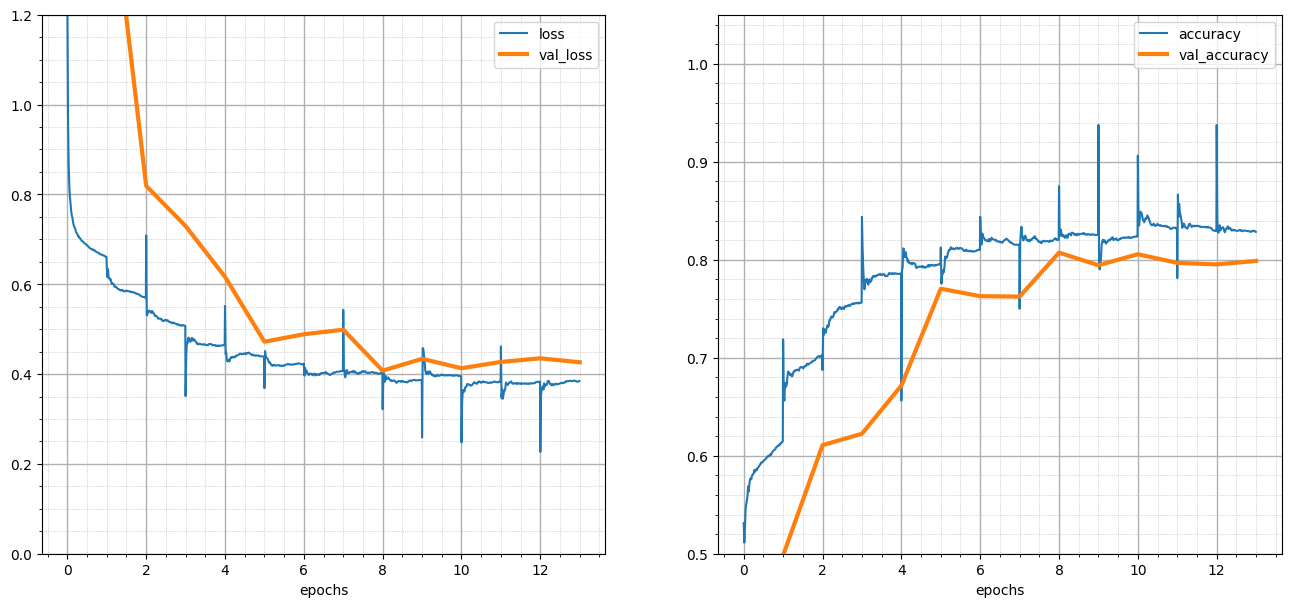

625/625 [==============================] - 63s 102ms/step - loss: 0.3845 - accuracy: 0.8285 - val_loss: 0.4262 - val_accuracy: 0.7988 - lr: 2.1768e-05


In [ ]:
#DROPOUT AFTER EVERY LAYER OF 0.5  #SEEMS LIKE IT'S TOO HIGH DROPOUT RATE THAT CAUSES UNDERFITTING, DESPITE LOWERING OVERFITTING
model_cnn.fit_model(20,True,True)

A dropout rate of 0.5 for every layer is too aggressive. The model underfits.

----------------------------------------------------------------------------------------------------------------------------------------------

I'm now trying to lower the dropout rates

In [ ]:
model_cnn = CNN_Model()

model_cnn.build_model([32,64,64,128,256],32,[(3,3),(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[0.3,0.3,0.3,0.3,0.3],True,[128],[0.5],True, True,0.01)
model_cnn.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model_cnn.print_summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_53 (Bat  (None, 200, 200, 32)     96        
 chNormalization)                                                
                                                                 
 activation_44 (Activation)  (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_45 (Conv2D)          (None, 100, 100, 64)    

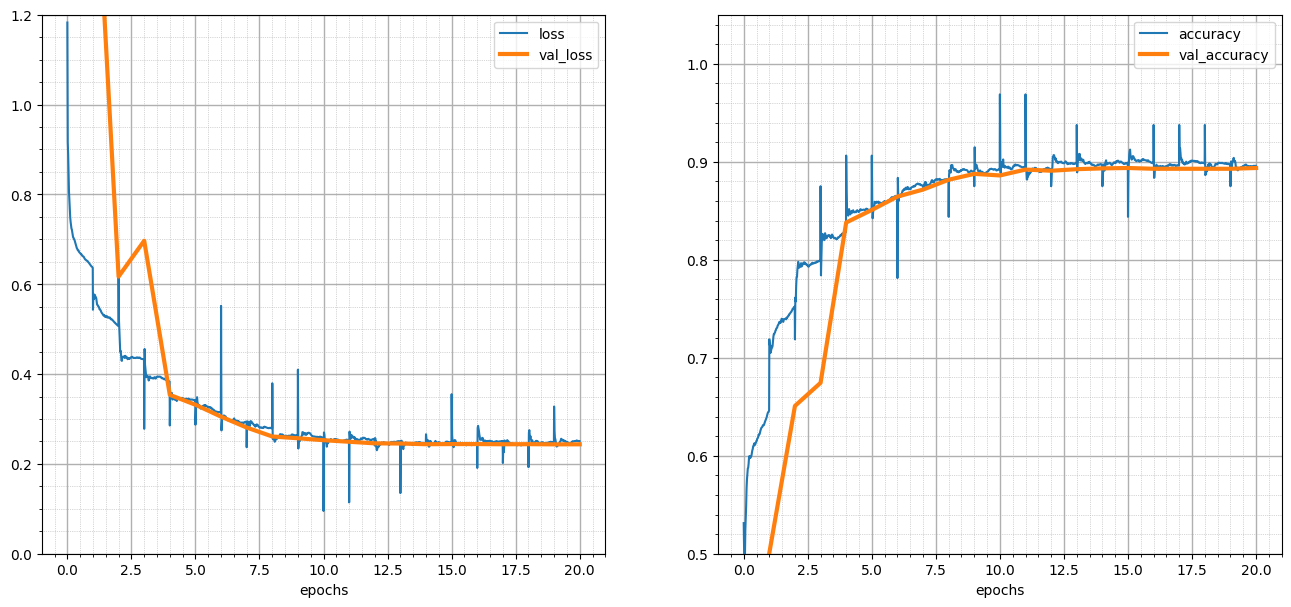

625/625 [==============================] - 63s 101ms/step - loss: 0.2505 - accuracy: 0.8958 - val_loss: 0.2436 - val_accuracy: 0.8936 - lr: 6.0936e-07


In [ ]:
#DROPOUT AFTER EVERY LAYER OF 0.3 exept last of 0.5
#IMPROVED A LOT AND WITH NO OVERFITTING
model_cnn.fit_model(20,True,True)

It improved a lot and with no overfitting.

-----------------------------------------------------------------------------------------------------------------------------------------------------------------

I lowered dropout rates further more

In [ ]:
model_cnn = CNN_Model()

model_cnn.build_model([32,64,64,128,256],32,[(3,3),(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[0.2,0.2,0.2,0.3,0.3],True,[128],[0.5],True, True,0.01)
model_cnn.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),False)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model_cnn.print_summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_65 (Bat  (None, 200, 200, 32)     96        
 chNormalization)                                                
                                                                 
 activation_54 (Activation)  (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_55 (Conv2D)          (None, 100, 100, 64)    

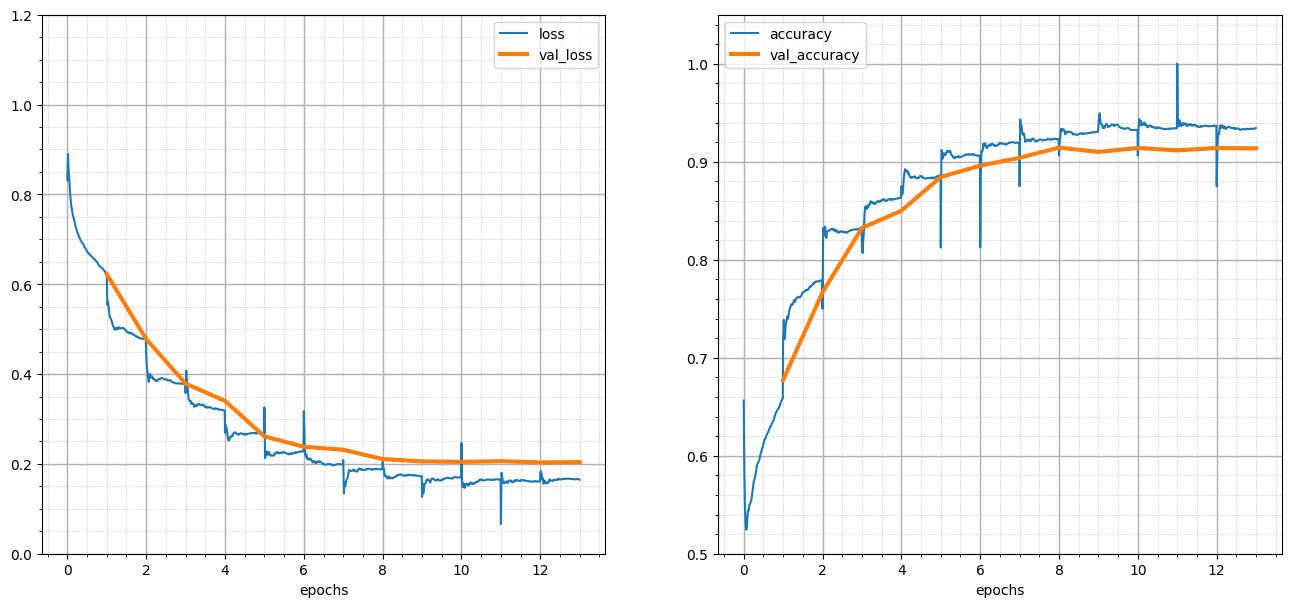

625/625 [==============================] - 63s 101ms/step - loss: 0.1649 - accuracy: 0.9344 - val_loss: 0.2040 - val_accuracy: 0.9136 - lr: 2.1768e-05


In [ ]:
#DROPOUT AFTER EVERY LAYER OF 0.2 exept last two with 0.3 and 0.5
#FURTHER IMPROVEMENT
model_cnn.fit_model(20,True,True)

Further improvement with lower dropout rates

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### IMAGE AUGMENTATION

I TRIED TO SEE IF ADDING AUGMENTED IMAGES TO THE PREVIOUS MODEL IMPROVES GNERALIZATION

In [ ]:
model_cnn = CNN_Model()

model_cnn.build_model([32,64,64,128,256],32,[(3,3),(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[0.2,0.2,0.2,0.3,0.3],True,[128],[0.5],True, True,0.01)
model_cnn.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),True)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model_cnn.print_summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_71 (Bat  (None, 200, 200, 32)     96        
 chNormalization)                                                
                                                                 
 activation_59 (Activation)  (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_60 (Conv2D)          (None, 100, 100, 64)    

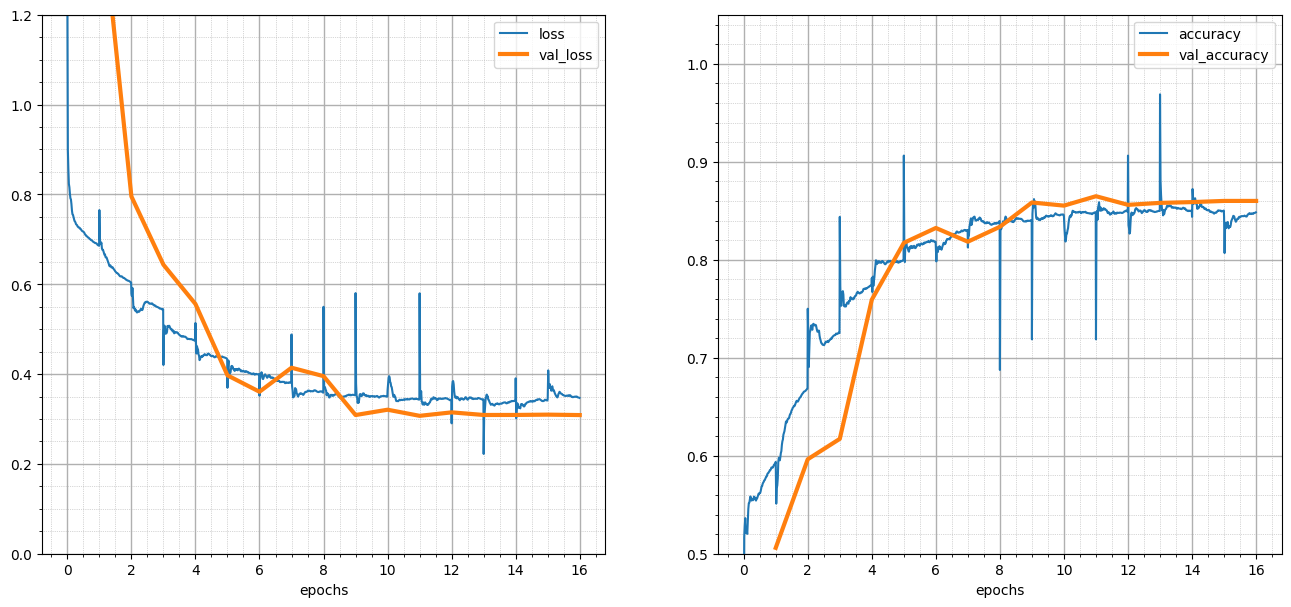

625/625 [==============================] - 78s 125ms/step - loss: 0.3470 - accuracy: 0.8482 - val_loss: 0.3087 - val_accuracy: 0.8600 - lr: 4.7018e-06


In [ ]:
#NOW TRIAL WITH AUGMENTED DATA
#DROPOUT AFTER EVERY LAYER OF 0.2 exept last two with 0.3 and 0.5
#little worse but no overfitting

model_cnn.fit_model(20,True,True)

Training with augmented images makes the model underfit. Generalization lower.

-----------------------------------------------------------------------------------------------------------------------------------------

To balance this, i tried to further lower dropouts rates

In [ ]:
model_cnn = CNN_Model()

model_cnn.build_model([32,64,64,128,256],32,[(3,3),(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[0.1,0.1,0.1,0.2,0.3],True,[128],[0.5],True, True,0.01)
model_cnn.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),True)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model_cnn.print_summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_77 (Bat  (None, 200, 200, 32)     96        
 chNormalization)                                                
                                                                 
 activation_64 (Activation)  (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_47 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_65 (Conv2D)          (None, 100, 100, 64)    

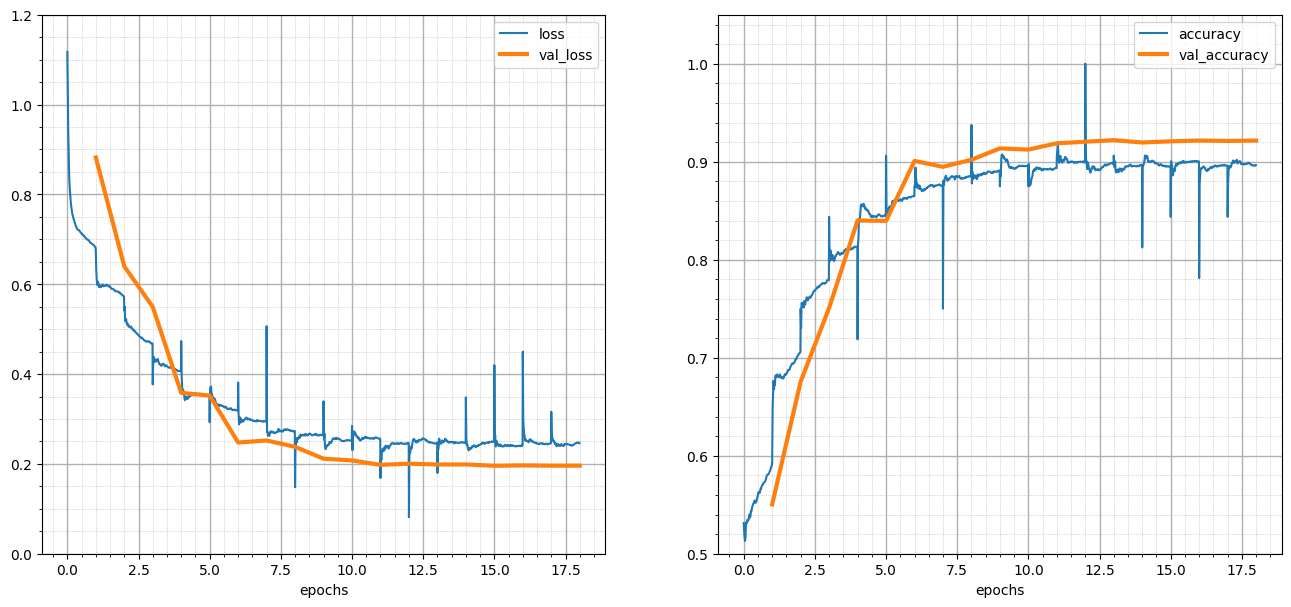

625/625 [==============================] - 114s 181ms/step - loss: 0.2456 - accuracy: 0.8969 - val_loss: 0.1961 - val_accuracy: 0.9216 - lr: 1.6927e-06


In [ ]:
#0.1,0.1,0.2,0.3,0.5
model_cnn.fit_model(20,True,True)

Lowering dropout rates seems to be wirking!

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

Lowering dropout rates further more

In [ ]:
model_cnn = CNN_Model()

model_cnn.build_model([32,64,64,128,256],32,[(3,3),(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[0.1,0.1,0.1,0.1,0.2],True,[128],[0.5],True, True,0.01)
model_cnn.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),True)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model_cnn.print_summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_83 (Bat  (None, 200, 200, 32)     96        
 chNormalization)                                                
                                                                 
 activation_69 (Activation)  (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_53 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_70 (Conv2D)          (None, 100, 100, 64)    

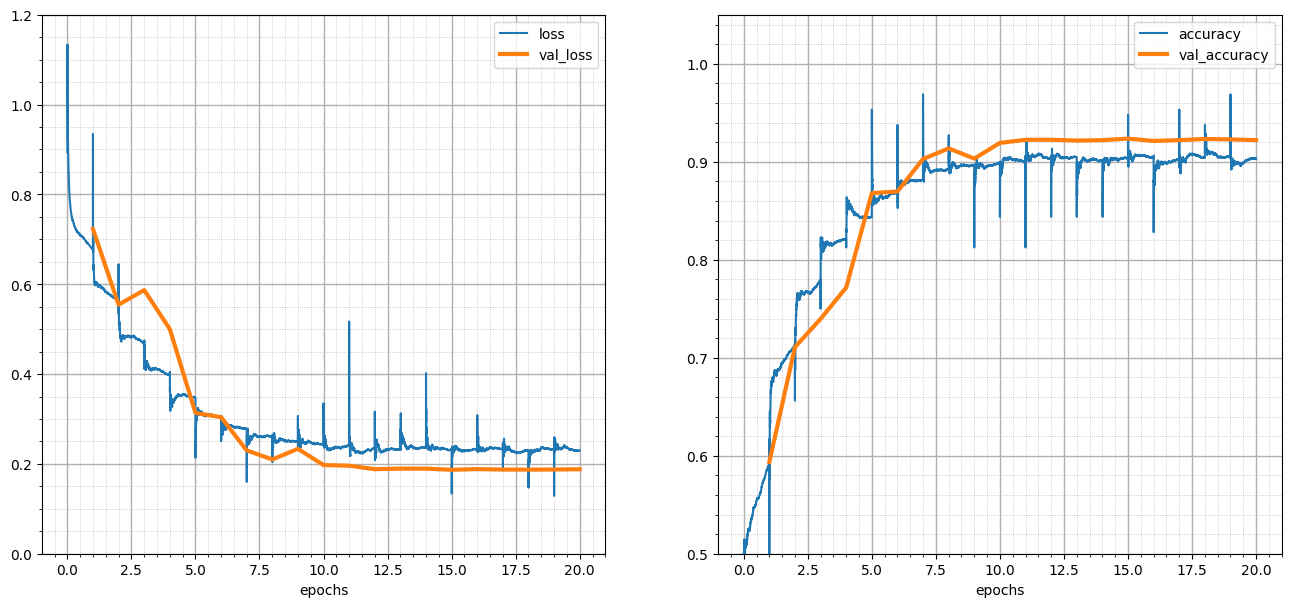

625/625 [==============================] - 113s 181ms/step - loss: 0.2299 - accuracy: 0.9032 - val_loss: 0.1881 - val_accuracy: 0.9220 - lr: 6.0936e-07


In [ ]:
#0.1,0.1,0.1,0.1,0.2,0.5 (CON AUGMENTATION)

model_cnn.fit_model(20,True,True)

No noticable changes!

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### trial without data augmentation

# Evaluation of CNN

The network I chose after many experiments is a consequence of the previous ones: 5 convolutional layers (32,64,64,128,256) and 1 dense layer.

I trained the model with augmented images, and put 1 dropout layer of 0.5 after the dense layer

In [ ]:
model_cnn = CNN_Model()

model_cnn.build_model([32,64,64,128,256],32,[(3,3),(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[1,1,1,1,1],True,[128],[0.5],True, True,0.01)
model_cnn.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),True)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model_cnn.print_summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_95 (Bat  (None, 200, 200, 32)     96        
 chNormalization)                                                
                                                                 
 activation_79 (Activation)  (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 100, 100, 64)      18496     
                                                                 
 batch_normalization_96 (Bat  (None, 100, 100, 64)   

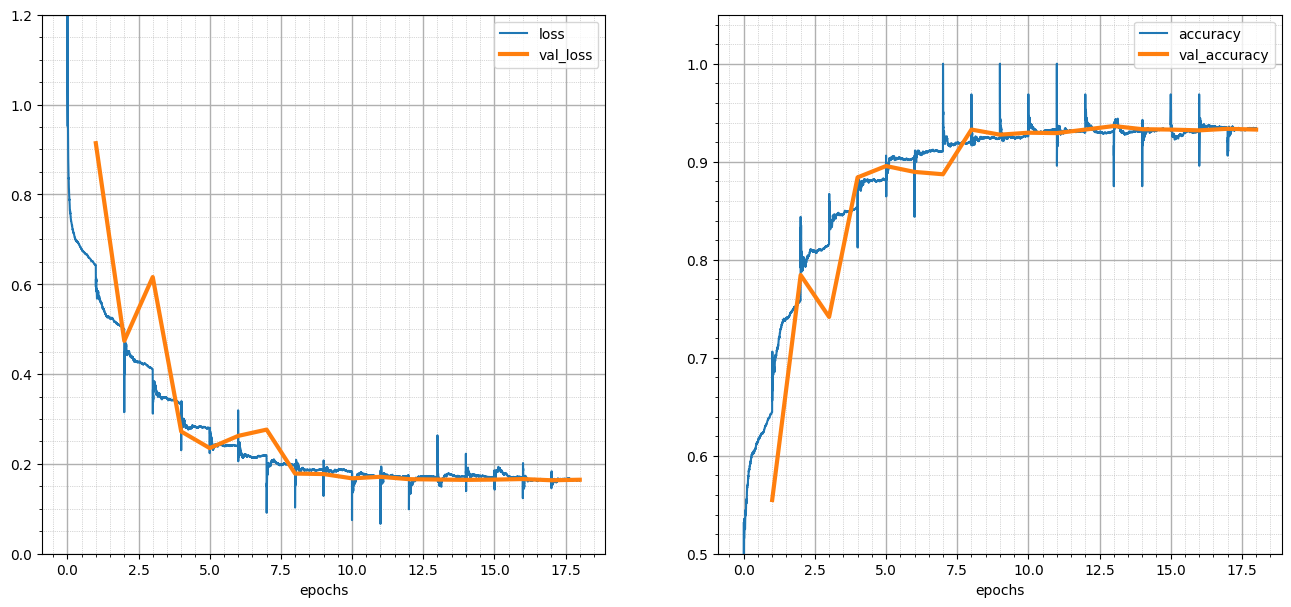

625/625 [==============================] - 111s 177ms/step - loss: 0.1631 - accuracy: 0.9343 - val_loss: 0.1647 - val_accuracy: 0.9328 - lr: 1.6927e-06


In [ ]:
#solo ultimo 0.5
model_cnn.fit_model(20,True,True)

In [ ]:
model_cnn.evaluate_model()

79/79 [==============================] - 7s 90ms/step - loss: 0.1327 - accuracy: 0.9484
Test loss: 0.1327168345451355 - Test accuracy: 0.9484000205993652
Precision: 0.941506
Recall: 0.954509
F1 score: 0.947963


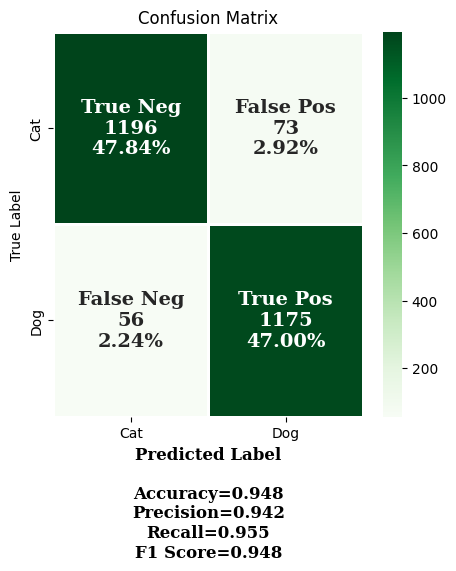

In [ ]:
model_cnn.print_confusion_matrix()

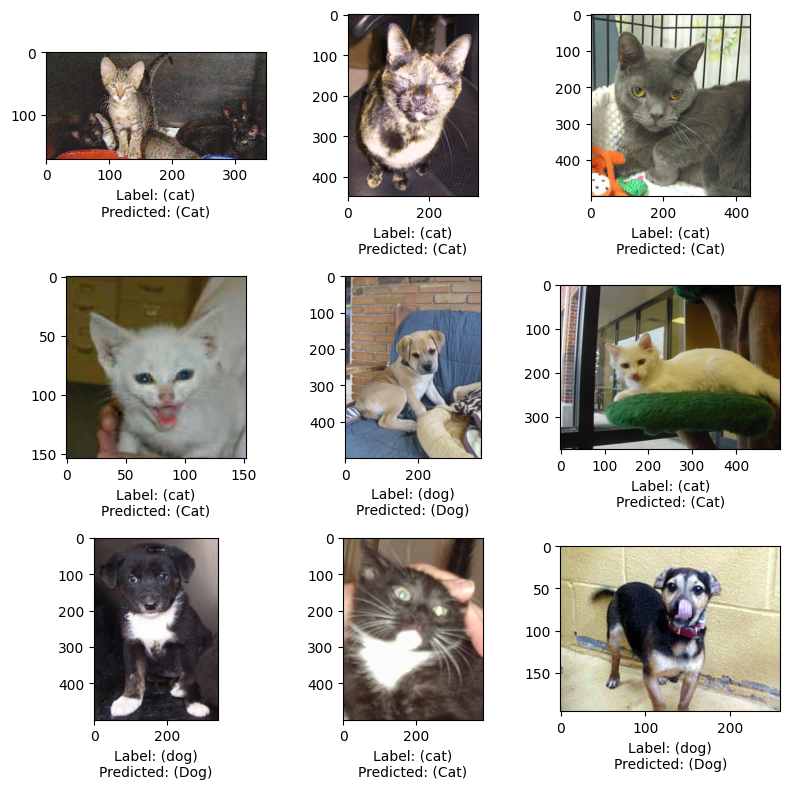

In [ ]:
sample_test = pred_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(8, 8))
for index, row in sample_test.iterrows():
    filename = row['image']
    category = row['label']
    category_pred = 'Cat'if row['predicted']==0 else 'Dog'
    path = 'Cats' if category == 'Cat' else 'Dogs'
    img = np.asarray(Image.open(filename))
    plt.subplot(3, 3, index+1)
    plt.imshow(img,cmap='Greys_r')
    #plt.xlabel(filename.split('/')[-1] + '  Category: (' + "{}".format(category) + ')')
    plt.xlabel('Label: (' + "{}".format(category) + ')\nPredicted: (' + "{}".format(category_pred) + ')')

plt.tight_layout()
#plt.title('Test data labels')
plt.show()

### Cross validation

In [ ]:
model_cnn = CNN_Model()

model_cnn.build_model([32,64,64,128,256],32,[(3,3),(3,3),(3,3),(3,3),(3,3)],(200,200,1),'same',[1,1,1,1,1],True,[128],[0.5],True, True,0.01)

In [ ]:
scores_cnn = cross_validate(model_cnn, ds)

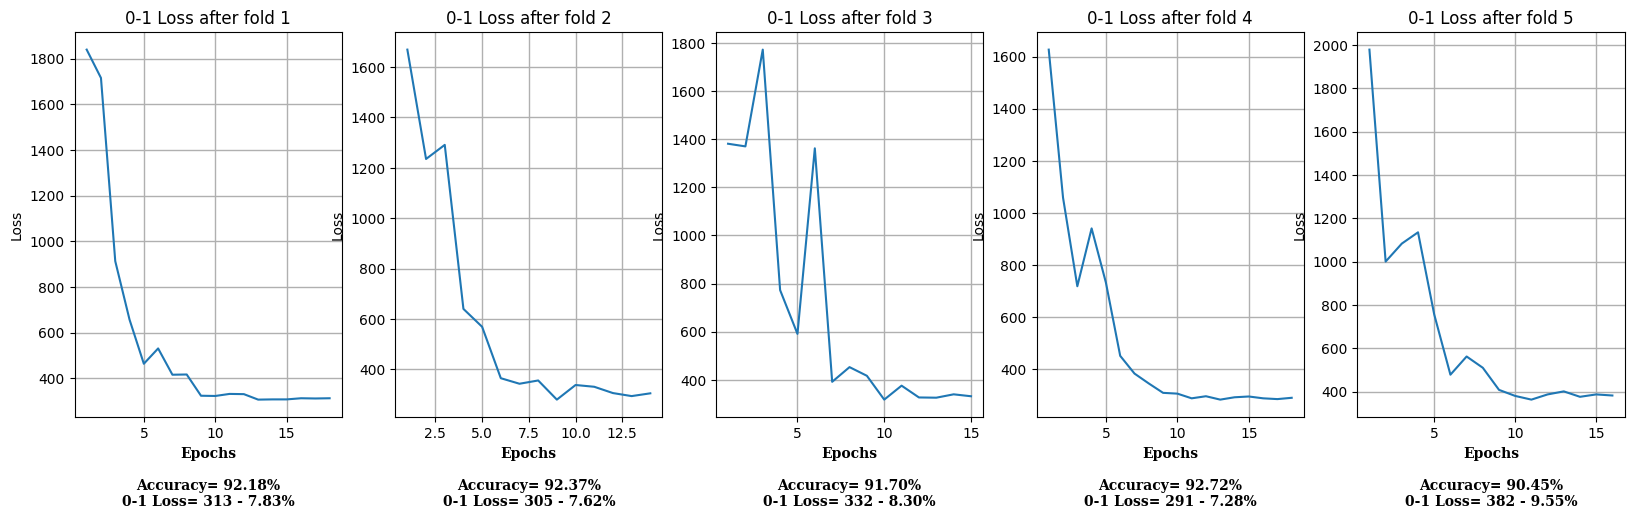

In [ ]:
print_cv_results(scores_cnn)

# VGG 16

In [ ]:
model_vgg = CNN_Model('vgg16')
model_vgg.build_model()
model_vgg.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),True)


Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model_vgg.print_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

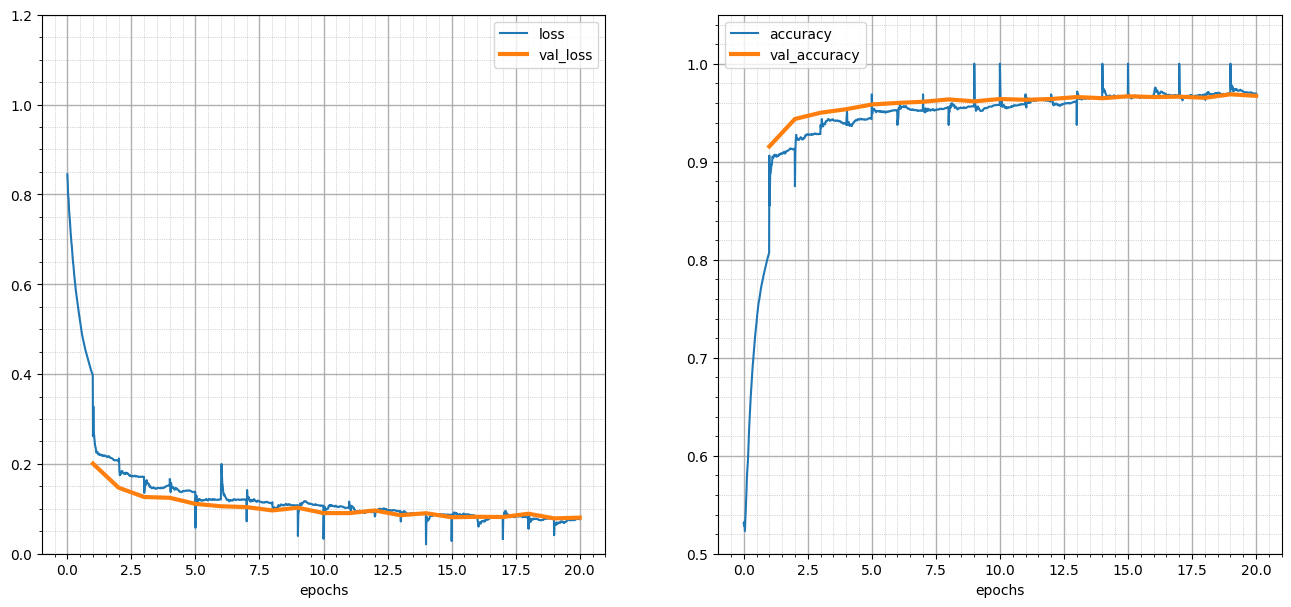

625/625 [==============================] - 205s 327ms/step - loss: 0.0772 - accuracy: 0.9695 - val_loss: 0.0804 - val_accuracy: 0.9672


In [ ]:
model_vgg.fit_model()

In [ ]:
model_vgg.evaluate_model()

79/79 [==============================] - 9s 110ms/step - loss: 0.0659 - accuracy: 0.9764
Test loss: 0.06587009876966476 - Test accuracy: 0.9764000177383423
Precision: 0.967305
Recall: 0.985378
F1 score: 0.976258


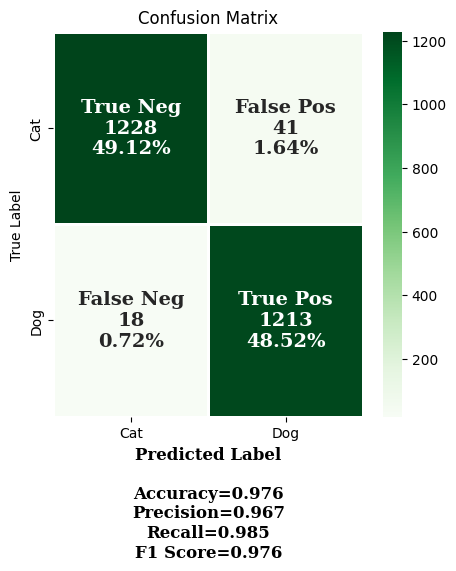

In [ ]:
model_vgg.print_confusion_matrix()

## Cross validation

In [ ]:
scores = cross_validate(model_vgg, ds)

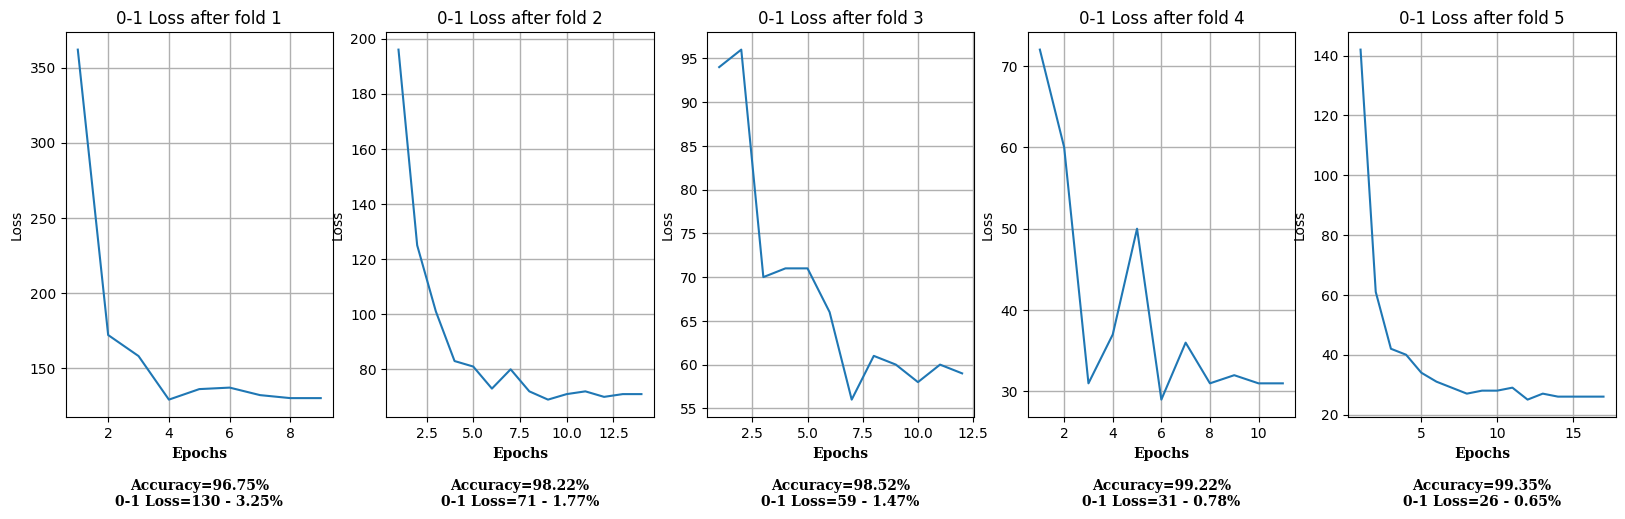

In [ ]:
print_cv_results(scores)

# ResNet50

In [ ]:
model_resnet = CNN_Model('resnet')
model_resnet.build_model()
model_resnet.generate_data(ds.get_images_set(),ds.get_train_set(),ds.get_val_set(),ds.get_test_set(),True)


94765736/94765736 [==============================] - 3s 0us/step
Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
model_resnet.print_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 200, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1)                 100353    
                                                                 
Total params: 23,688,065
Trainable params: 23,634,945
Non-trainable params: 53,120
_________________________________________________________________
None


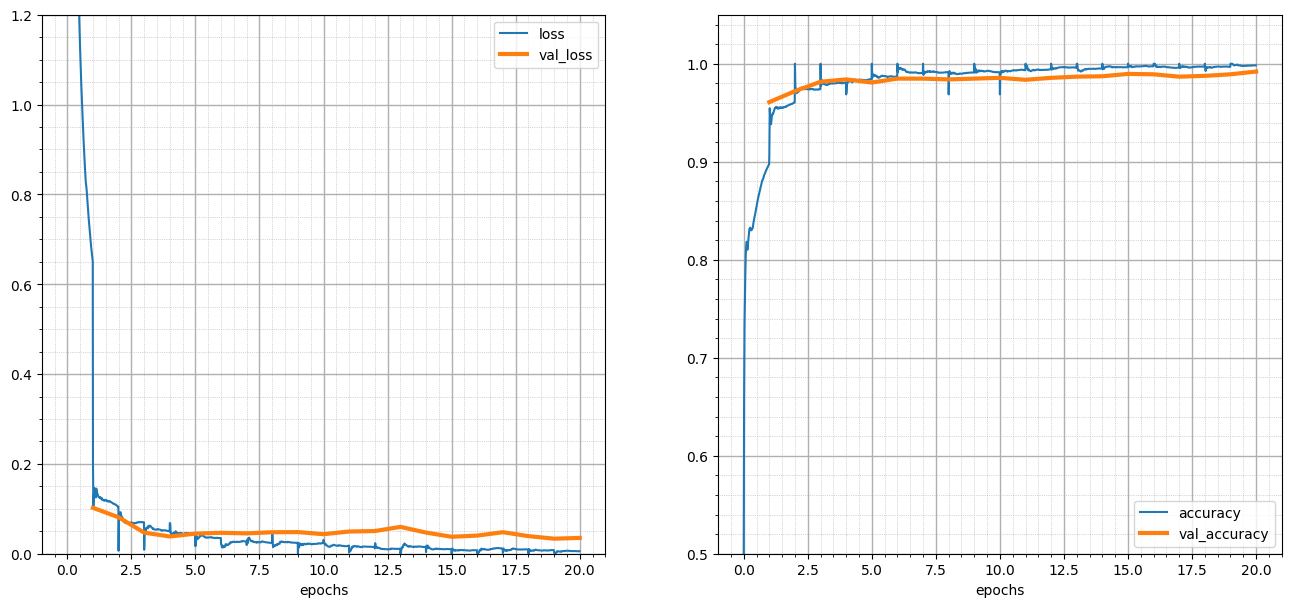

625/625 [==============================] - 229s 366ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.0352 - val_accuracy: 0.9920


In [ ]:
model_resnet.fit_model()

In [ ]:
model_resnet.evaluate_model()

79/79 [==============================] - 9s 106ms/step - loss: 0.0471 - accuracy: 0.9884
Test loss: 0.04707740992307663 - Test accuracy: 0.9883999824523926
Precision: 0.991817
Recall: 0.984565
F1 score: 0.988178


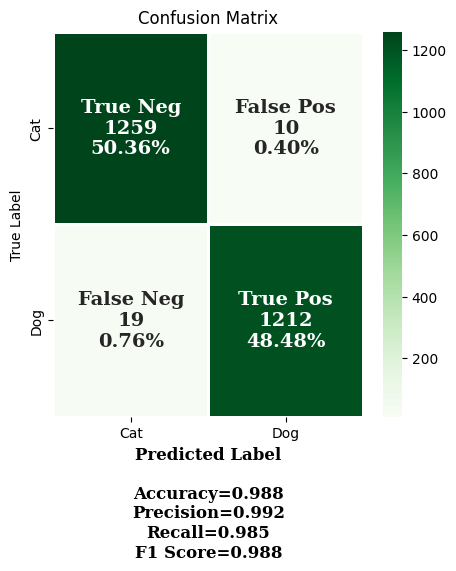

In [ ]:
model_resnet.print_confusion_matrix()

## Cross validation

In [ ]:
scores = cross_validate(model_resnet, ds)

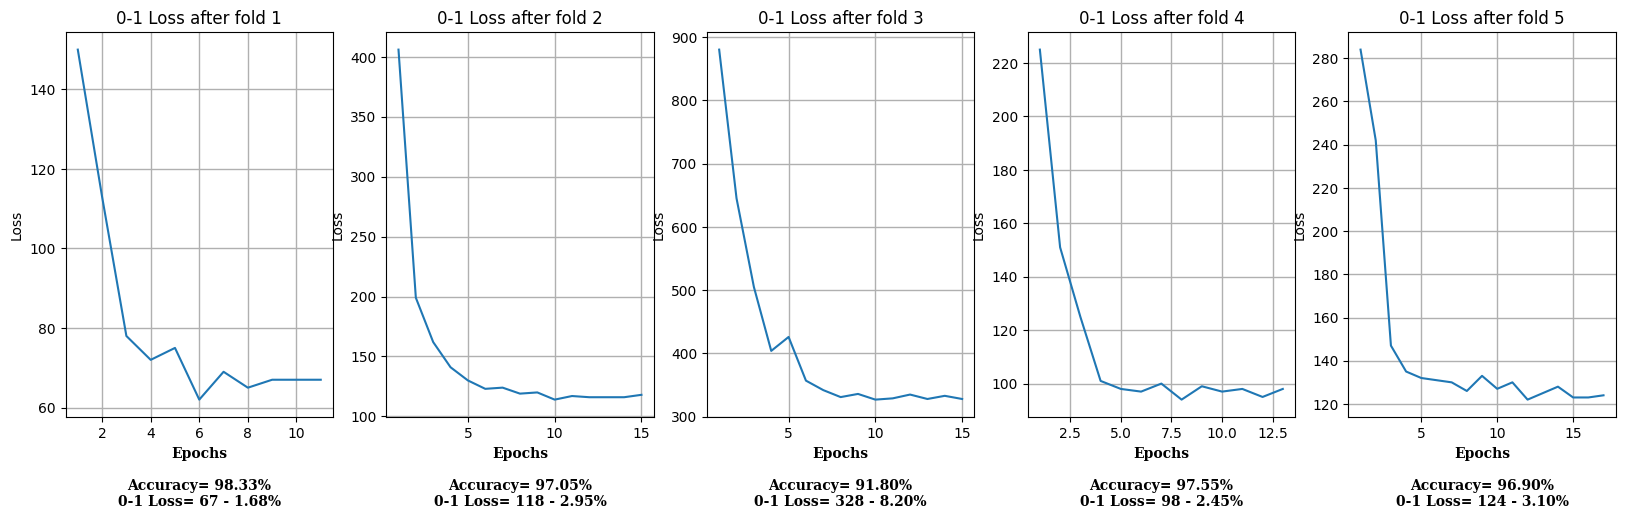

In [ ]:
print_cv_results(scores)